<a href="https://colab.research.google.com/github/BhanuTeja4/BhanuTeja4.github.io/blob/main/Code/damage_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The code was a part of my project under one of the `ETE MSc Course (Advanced Artificial Intelligence)`**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [7]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re, nltk, json
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, roc_curve, precision_recall_curve)
from tensorflow.keras.utils import plot_model


# Set random seed for reproducibility
np.random.seed(42)

# Download necessary NLTK resources
nltk.download('punkt')

# Import NLP libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, ToktokTokenizer
import string, spacy, unicodedata, random
from bs4 import BeautifulSoup

# Class for colored text output
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Dataset paths
dataset_root = "/content/drive/MyDrive/multimodal/"
train_excel = os.path.join(dataset_root, "train.xlsx")
test_excel = os.path.join(dataset_root, "test.xlsx")

print(f"Train file: {train_excel}")
print(f"Test file: {test_excel}")


Train file: /content/drive/MyDrive/multimodal/train.xlsx
Test file: /content/drive/MyDrive/multimodal/test.xlsx
CPU times: user 29.2 ms, sys: 3.58 ms, total: 32.7 ms
Wall time: 33.6 ms


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Dense, GlobalAveragePooling2D, Embedding, LSTM, multiply
from keras.models import Model
from keras import preprocessing, Input
from tensorflow import keras
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from tensorflow.keras.models import load_model
import itertools
from PIL import Image, ImageFile
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D,MaxPooling1D,Conv1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Add, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Nadam
keras.backend.clear_session()

#Fetching Dataset

In [9]:
train_data = pd.read_excel(dataset_root+'train.xlsx')
test_data = pd.read_csv(dataset_root+'test.xlsx')

In [10]:
train_data.columns

Index(['filename', 'tweet', 'label', 'image'], dtype='object')

In [11]:
train_data['label'].value_counts()

,count
label,
non_damage,2666
damaged_infrastructure,1246
damaged_nature,459
flood,348
fires,309
human_damage,219


In [12]:
test_data['label'].value_counts()

,count
label,
non_damage,291
damaged_infrastructure,144
damaged_nature,55
fires,37
flood,36
human_damage,21


In [13]:
train_data['enc_label'] = train_data['label'].replace({'non_damage':0,'damaged_infrastructure':1,'damaged_nature':2,
                                                       'fires':3,'flood':4,'human_damage':5 })
test_data['enc_label'] = test_data['label'].replace({'non_damage':0,'damaged_infrastructure':1,'damaged_nature':2,
                                                     'fires':3,'flood':4,'human_damage':5 })

In [14]:
print("Size of the training data ==> ", train_data.shape)
print("Size of the Test data ==>", test_data.shape)

Size of the training data ==>  (5247, 5)
Size of the Test data ==> (584, 5)


In [15]:
def replace_string(row):
  return row.replace('.JPG', '.jpg')

train_data['image'] = train_data['image'].apply(replace_string)
test_data['image'] = test_data['image'].apply(replace_string)

## Display Some Data

In [16]:
train_data[train_data['enc_label']==0]['tweet'].tail(50)

,tweet
5154,1•Dia da #CruzadaEvangelistica dos #Jovens na ...
5155,"""Circulação""\n#SJ_179"
5157,#mondaymotivation looking back at the progress...
5162,The new bae. If you're like me and literally A...
5163,"This could be your key chain, apparel accessor..."
5166,Falling in love with @es.and.her grazing table...
5169,A VOLTE DEVI DIMENTICARE CIÒ CHE DESIDERI E RI...
5171,WhatsApp On +919466780004 #earrings #jhumki #c...
5174,#AD Everybody go shop @remymartinstudios she h...
5175,Ingredienti per una giornata di pioggia: un in...


In [ ]:
## Non-damage --> 5205
## D-I --> 5227
## D-N --> 5020
## Fires -->  4808
## Flood -->  210
## HD --> 434

Tweet for this Image:
 The Syrian genocide continues..........#assadcrimes #isiscrimes #pain #syria #syrie #syrians #syriangenocide #syrianrefugees #shameonhumanity #shameonthisworld


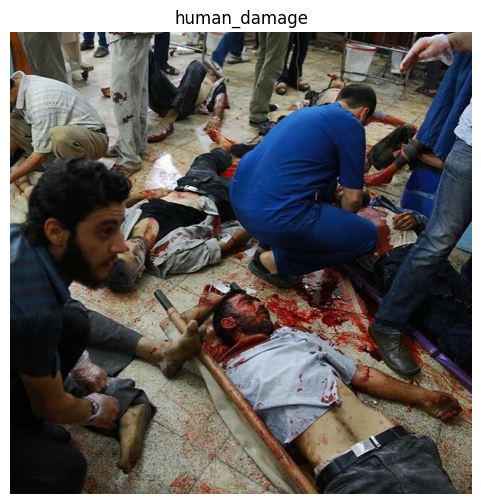

In [17]:
n = 434

# Get the label of the current sample
label = train_data['label'][n]

# Construct the correct path for the image
image_path = f"{dataset_root}{label}/images/{train_data['image'][n]}"

# Load the image
from matplotlib import image as im
data = im.imread(image_path)

# Display the image
plt.figure(figsize=(6, 6))
plt.axis('off')  # Hide axis
plt.imshow(data)
plt.title(label)  # Display the label as the title
plt.savefig(dataset_root + "human-D.png", bbox_inches='tight')

# Print the corresponding tweet
print("Tweet for this Image:\n", train_data['tweet'][n])


## Image Fetching

In [18]:
## collect image names from the folders
def create_img_array(img_dirct):
    all_imgs = []
    for root, j, files in os.walk(img_dirct):
        for file in files:
            file = root + '' + file
            all_imgs.append(file)
    return all_imgs

def create_img_path(DF, Col_name, img_dir):
    img_path = [img_dir + '' + name for name in DF[Col_name]]
    return img_path

In [19]:
# Creating train, test and validation image path
train_img_path = create_img_path(train_data,'image', dataset_root)
test_img_path = create_img_path(test_data,'image', dataset_root)

In [20]:
# Function that returns image reading from the path
def get_input(path):
    # Loading image from given path
    # and resizing it to 150*150*3 format
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    img= image.load_img(path, target_size=(150,150))
    # img.close()
    return(img)

# Takes in image and preprocess it
def process_input(img):
    # Converting image to array
    img_data = image.img_to_array(img)
    # Adding one more dimension to array
    img_data = np.expand_dims(img_data, axis=0)
    #
    img_data = preprocess_input(img_data)
    #img_data = preprocess_input(img_data)
    return(img_data)


In [21]:
# Create an array of training images
train_images = []
for n,i in enumerate(train_img_path):
  label = train_data['label'][n]
  img_path = os.path.join(dataset_root, label, 'images', train_data['image'][n])
  input_img = get_input(img_path)
  process_img = process_input(input_img)
  train_images.append(process_img[0])

In [22]:
# Create an array of training images
test_images = []
for n,i in enumerate(test_img_path):
  label = test_data['label'][n]
  img_path = os.path.join(dataset_root, label, 'images', test_data['image'][n])
  input_img = get_input(img_path)
  process_img = process_input(input_img)
  print(n)
  test_images.append(process_img[0])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [23]:
# convert into numpy array
train_image = np.array(train_images)
# convert into numpy array
test_image = np.array(test_images)

In [ ]:
import pickle as pkl
with open(dataset_root+'train.pkl','wb') as f:
    pkl.dump(train_image, f)

with open(dataset_root+'test.pkl','wb') as f:
    pkl.dump(test_image, f)

In [23]:
import pickle as pkl

with open(dataset_root+'train.pkl','rb') as f:
  train_image = pkl.load(f)
  print("Training Images:-- ",train_image.shape)

with open(dataset_root+'test.pkl','rb') as f:
  test_image = pkl.load(f)
  print("Test Images:-- ",test_image.shape)

Training Images:--  (5247, 150, 150, 3)
Test Images:--  (584, 150, 150, 3)


## One Hot Encoding

In [24]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [25]:
encoder=OneHotEncoder(sparse_output=False)

encoded_labels = pd.DataFrame (encoder.fit_transform(train_data[['label']]))

encoded_labels .columns = encoder.get_feature_names_out(['label'])

train_data= pd.concat([train_data, encoded_labels ], axis=1)

In [26]:
train_data.columns

Index(['filename', 'tweet', 'label', 'image', 'enc_label',
       'label_damaged_infrastructure', 'label_damaged_nature', 'label_fires',
       'label_flood', 'label_human_damage', 'label_non_damage'],
      dtype='object')

In [27]:
train_data = train_data.rename(columns={'label_damaged_infrastructure':'damaged_infrastructure', 'label_damaged_nature':'damaged_nature',
                                        'label_fires':'fires','label_flood':'flood',
                                        'label_human_damage':'human_damage', 'label_non_damage':'non_damage'})
train_data

,filename,tweet,label,image,enc_label,damaged_infrastructure,damaged_nature,fires,flood,human_damage,non_damage
0,buildingfire_2017-02-05_04-06-10.txt,Here's some video of the smoldering ruins in W...,damaged_infrastructure,buildingfire_2017-02-05_04-06-10.jpg,1,1.0,0.0,0.0,0.0,0.0,0.0
1,isiscrimes_2015-08-04_00-18-33.txt,27 person were killed yesterday near idlib nor...,human_damage,isiscrimes_2015-08-04_00-18-33.jpg,5,0.0,0.0,0.0,0.0,1.0,0.0
2,earthquake_2017-11-13_07-23-10.txt,تصویری از خسارات زلزله در سرپل ذهاب\n#earthqua...,damaged_infrastructure,earthquake_2017-11-13_07-23-10.jpg,1,1.0,0.0,0.0,0.0,0.0,0.0
3,ad_2017-11-25_07-56-53.txt,Link in bio #fashion #style #dt #friends #Inst...,non_damage,ad_2017-11-25_07-56-53.jpg,0,0.0,0.0,0.0,0.0,0.0,1.0
4,hurricanesandy_2017-10-29_22-36-42.txt,Covering the aftermath of Hurricane #Sandy 5 y...,flood,hurricanesandy_2017-10-29_22-36-42.jpg,4,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5242,cars_2017-10-30_17-48-22.txt,Tuner Evo SoCal \nOfficial Vendor/Sponsor \n@t...,non_damage,cars_2017-10-30_17-48-22.jpg,0,0.0,0.0,0.0,0.0,0.0,1.0
5243,buildingfire_2016-12-07_17-48-56.txt,Building fire yesterday in Boulder City #fire ...,fires,buildingfire_2016-12-07_17-48-56.jpg,3,0.0,0.0,1.0,0.0,0.0,0.0
5244,nature_2017-10-30_17-47-15.txt,Walking in the forest is soooooo relaxing ! \n...,non_damage,nature_2017-10-30_17-47-15.jpg,0,0.0,0.0,0.0,0.0,0.0,1.0
5245,ad_2017-11-25_11-07-37.txt,"a blue dream,💙 Use the code ""VANESSA35"" to get...",non_damage,ad_2017-11-25_11-07-37.jpg,0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
train_data.columns

Index(['filename', 'tweet', 'label', 'image', 'enc_label',
       'damaged_infrastructure', 'damaged_nature', 'fires', 'flood',
       'human_damage', 'non_damage'],
      dtype='object')

In [29]:
train_data.tweet = train_data.tweet.astype(str)

## Text Cleaning

In [30]:
'''
Text Cleaning
'''
def text_cleaning(row):
  #to remove HTML tags
  text = BeautifulSoup(row, 'html.parser').get_text()
  d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #This line is for removing url
  post = d.replace('\n', '')
  post = post.replace('—', ' ')
  # to remove accented characters
  # to remove special characters and numbers
  # define the pattern to keep
  pat = r'[^#@a-zA-z0-9]'
  text = re.sub(pat, ' ', post)
  #to remove punctuation
  #text = ''.join([c for c in text if c not in string.punctuation])
  # to remove special characters
  #pattern = r'^\s*|\s\s*'
  #text = re.sub(pattern, ' ', text).strip()
  # convert into lower case
  text = text.lower()
  # Stopword Removing
  #tokenizer = ToktokTokenizer()
  # convert sentence into token of words
  #tokens = tokenizer.tokenize(text)
  #tokens = [token.strip() for token in tokens]


  return text

In [31]:
#Removing punctuations
train_data['cleaned'] = train_data['tweet'].apply(text_cleaning)
test_data['cleaned'] = test_data['tweet'].apply(text_cleaning)


## Data samples after cleaning
print("Data samples after cleaning:\n")
for i in range(10):
  print("Original Data:===\n",train_data.tweet[i],"\nCleaned Data:===\n",train_data.cleaned[i],)

Data samples after cleaning:

Original Data:===
 Here's some video of the smoldering ruins in White Hall, IL. When I left I smelled like a campfire. 3 massive buildings destroyed by a giant fire. A local woman told me about it all. Just unbelievably sad. So much history and such a historic loss in a really small town. #smalltownusa #whitehall #centralillinois #illinois_shots #architecture #brickstagram #firedamage #buildingruins #exploreillinois #buildingfire 
Cleaned Data:===
 here s some video of the smoldering ruins in white hall  il  when i left i smelled like a campfire  3 massive buildings destroyed by a giant fire  a local woman told me about it all  just unbelievably sad  so much history and such a historic loss in a really small town  #smalltownusa #whitehall #centralillinois #illinois_shots #architecture #brickstagram #firedamage #buildingruins #exploreillinois #buildingfire
Original Data:===
 27 person were killed yesterday near idlib north of Syria, in mass massacre conduct

## Data Statistics

In [32]:
## Individual tweets length calculation
def char_length(row):
    return len(row.split())


lables = ['non_damage','damaged_infrastructure','damaged_nature',
                                                       'fires','flood','human_damage']
# Count number of unique words in each set
def dataset_statistics(dataset):
  for l in lables:
    word_list = [word.strip() for t in list(dataset[dataset[l]==1].cleaned) for word in t.strip().split()]
    counts = dict()
    for word in word_list:
        counts[word] = counts.get(word, 0)+1
      # sort the dictionary of word list
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    print(f"\nClass Name:--> {l} ")
    print("Number of Words:{}".format(len(word_list)))
    print("Number of Unique Words:{}".format(len(np.unique(word_list))))
    print("Maximum post length: {}".format(max(dataset[dataset[l]==1].cleaned.apply(char_length))))
    print("Average Words in texts: {}".format(np.mean(dataset[dataset[l]==1].cleaned.apply(char_length))))
    print(color.BOLD+"\nMost Frequent Words:\n"+color.END)
    for k,v in ordered[:10]:
      print("{}\t{}".format(k,v))


In [33]:
dataset_statistics(train_data)


Class Name:--> non_damage 
Number of Words:111686
Number of Unique Words:25978
Maximum post length: 382
Average Words in texts: 41.8927231807952

Most Frequent Words:

the	1955
and	1619
to	1560
a	1547
#	1442
#ad	1441
i	1149
it	939
for	927
you	882

Class Name:--> damaged_infrastructure 
Number of Words:35202
Number of Unique Words:10244
Maximum post length: 363
Average Words in texts: 28.252006420545747

Most Frequent Words:

the	1155
#	648
and	596
of	529
in	513
a	477
to	447
#wreckedcar	317
_	235
it	211

Class Name:--> damaged_nature 
Number of Words:13230
Number of Unique Words:5417
Maximum post length: 345
Average Words in texts: 28.823529411764707

Most Frequent Words:

the	421
a	205
to	196
and	188
of	181
in	171
is	108
this	98
it	90
we	88

Class Name:--> fires 
Number of Words:11809
Number of Unique Words:4055
Maximum post length: 382
Average Words in texts: 38.2168284789644

Most Frequent Words:

the	427
and	241
of	217
in	210
to	196
fire	169
a	166
#fire	128
#forrestfire	99
is	99

C

##Varying Length Distribution

In [34]:
def comments_length_per_class(dataset):
  label = dataset[['damaged_infrastructure', 'damaged_nature', 'fires', 'flood', 'human_damage', 'non_damage']]
  label = label.values
  comment = dataset['cleaned']
  comment = comment.values
  y = np.zeros(label.shape)
  for ix in range(comment.shape[0]):
      l = len(comment[ix].split())
      if label[ix][0] :
          y[ix][0] = l
      if label[ix][1] :
          y[ix][1] = l
      if label[ix][2] :
          y[ix][2] = l
      if label[ix][3] :
          y[ix][3] = l
      if label[ix][4] :
          y[ix][4] = l
      if label[ix][5] :
          y[ix][5] = l

  labelsplt = ['DI', 'DN', 'Fires', 'Flood', 'HD', 'ND']
  color = ['crimson','green','blue','yellow','chartreuse','purple']
  bins = [1,20,40,60,80,100]
  #plt.title (f'Comments Length Per Class ({set_name} Set)')
  plt.figure(figsize=(5,3))
  #plt.title ('Posts Length Per Class')
  plt.hist(y,bins = bins,label = labelsplt,color = color)
  plt.axis([0, 100, 0, 1100])
  plt.xlabel('Length of tweets')
  plt.ylabel('Number of tweets')
  plt.legend()
  plt.savefig(dataset_root+'length-dist.png',dpi = 500,bbox_inches ='tight')
  #plt.grid(True)
  plt.show()

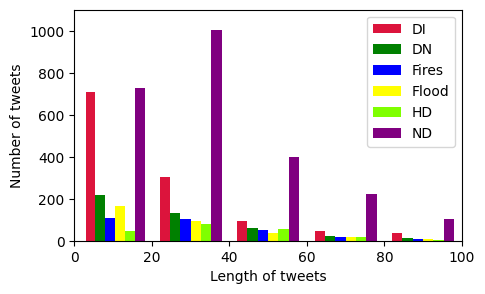

In [35]:
comments_length_per_class(train_data)

##Evaluation Metrics

In [36]:
'''Evaluation Parameters'''

def print_metrices(true,pred):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred))
    print("Accuracy : ",accuracy_score(true,pred))
    print("Precison : ",precision_score(true,pred, average = 'weighted'))
    print("Recall : ",recall_score(true,pred,  average = 'weighted'))
    print("F1 : ",f1_score(true,pred,  average = 'weighted'))

## Confusion Matrix

In [37]:
## Confusion matrix function
def con_mat(true,pred,class_names,model_name):
  cm = confusion_matrix(true,pred)
  #sns.set()
  plt.figure(figsize =(4, 3))
  ax = plt.subplot()
 # 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            #'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
  sns.heatmap(cm, annot=True,fmt="d",cmap='YlOrRd', ax = ax,annot_kws={"size": 10},) #annot=True to annotate cells
  # labels, title and ticks
  ax.set_xlabel('Predicted labels',fontsize=10)
  ax.set_ylabel('True labels',fontsize=10)
  #ax.set_title(f'Confusion Matrix of {model_name}',fontsize=10)
  ax.xaxis.set_ticklabels(class_names, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
  ax.xaxis.tick_top()
 # plt.savefig(folder_path + f"{model_name}.png",bbox_inches='tight',dpi =500)

#Textual Models

## Length Frequency Distribution

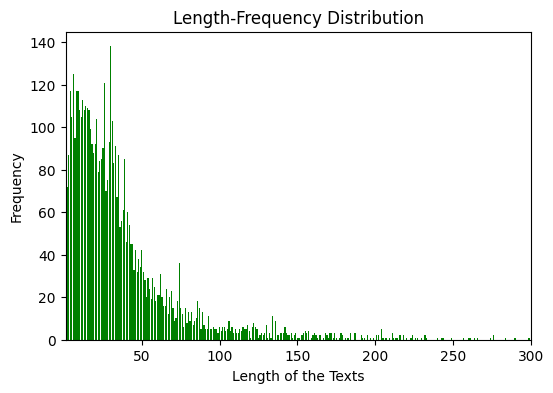

In [38]:
train_data['length'] = train_data['cleaned'].apply(char_length)
plt.figure(figsize=(6,4))
frequency = dict()
for i in train_data.length:
  frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="g")
plt.xlim(1, 300)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.savefig(dataset_root+'len_dist.png',dpi = 700,bbox_inches ='tight')

## Tokenizer

In [39]:
''' Tokenizer '''

def text_tokenizer(train_data,test_data,vocabulary,max_len,sample_text_num):

  tokenizer = Tokenizer(num_words = vocabulary ,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-',
                        split=' ', char_level=False, oov_token='<oov>', document_count=0)
  tokenizer.fit_on_texts(train_data['cleaned'])
  word_index = tokenizer.word_index
  vocab_size = len(word_index)+1

  # Training Sequences
  train_sequences = tokenizer.texts_to_sequences(train_data['cleaned'])
  train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)

  # Test Sequences
  test_sequences = tokenizer.texts_to_sequences(test_data['cleaned'])
  test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)


  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\n")
  print(train_data.cleaned[sample_text_num],"\n",train_sequences[sample_text_num])
  print(color.BOLD+"\n\t\t\t====== Paded Sequences ======\n"+color.END,"\n",train_pad_sequences[sample_text_num])

  return train_pad_sequences, test_pad_sequences, vocab_size, word_index


vocabulary = 50000
max_len = 150
sample_text_num = 10

## Call Tokenizer
train_pad_sequences, test_pad_sequences, vocab_size, word_index =  text_tokenizer(train_data,test_data,
                                                                      vocabulary,max_len,sample_text_num)

print("Number of Train Sequences :" ,train_pad_sequences.shape)
print("Number of Test Sequences :" ,test_pad_sequences.shape)
print("Vocabulary Size: ",vocab_size)


			====== Encoded Sequences ====== 

tonight s dinner comes to you live from a beautiful gold coast beach  from my fave  orchid vegetarian here on the gold coast   i believe that it s important to support our very own local small businesses and it s especially easy when it looks and tastes this good  @ubereats_aus delivered this spread to my door and i think the only  and most aussie  way to describe this spread is  frothinnn      #ubereats #ubereatsaus #ad 
 [755, 16, 928, 615, 4, 13, 404, 23, 5, 52, 756, 1255, 170, 23, 17, 6032, 13395, 3090, 108, 15, 2, 756, 1255, 8, 1041, 21, 10, 16, 1386, 4, 396, 38, 256, 602, 612, 558, 1693, 3, 10, 16, 893, 446, 63, 10, 694, 3, 8108, 14, 116, 8109, 2102, 8110, 14, 2800, 4, 17, 1694, 3, 8, 338, 2, 173, 3, 287, 6033, 215, 4, 3091, 14, 2800, 12, 13396, 8109, 13397, 9]

			====== Paded Sequences ======
 
 [  755    16   928   615     4    13   404    23     5    52   756  1255
   170    23    17  6032 13395  3090   108    15     2   756  1255     8
 

In [40]:
## Convert labels into array
y_train = np.array(train_data['enc_label']).reshape(-1,1)
y_test = np.array(test_data['enc_label']).reshape(-1,1)

## Callbacks

In [41]:
''' Callbacks'''
keras.backend.clear_session()
def callbacks_check(model_name):
  num_classes = 6
  accuracy_threshold = 0.99

  class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>accuracy_threshold):
          print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
          self.model.stop_training = True

  acc_callback = myCallback()
  # Saved the Best Model
  filepath = dataset_root+'Models/'+f"{model_name}.h5"
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
  # callback list
  callback_list = [acc_callback, checkpoint]

  return callback_list

## Textual Models (Keras Embeddings)

In [40]:
def create_keras_embeddings_models(max_len):

  ###### BiLSTM Model #######
  bi_text_inputs = Input(shape=(max_len,))
  bi_embedding_layer = Embedding(vocab_size, 100)(bi_text_inputs)
  LSTM_Layer_1 = Bidirectional(LSTM(128,dropout=0.01))(bi_embedding_layer)
  bi_dense_layer_1 = Dense(6, activation='softmax')(LSTM_Layer_1)
  bilstm_model = Model(inputs=bi_text_inputs, outputs=bi_dense_layer_1)

  ##### CNN Model  #######
  cnn_text_inputs = Input(shape=(max_len,))
  cnn_embedding_layer = Embedding(vocab_size, 100)(cnn_text_inputs)
  cnn_conv1 = Conv1D(128,2,activation='relu')(cnn_embedding_layer)
  cnn_pool1 = MaxPooling1D(2)(cnn_conv1)
  cnn_flat = Flatten()(cnn_pool1)
  cnn_dense_layer_1 = Dense(6, activation='softmax')(cnn_flat)
  cnn_model = Model(inputs=cnn_text_inputs, outputs=cnn_dense_layer_1)


  ##### LSTM-CNN Model ####
  lc_text_inputs = Input(shape=(max_len,))
  lc_embedding_layer = Embedding(vocab_size, 100)(lc_text_inputs)
  LSTM_Layer = Bidirectional(LSTM(128,return_sequences=True,dropout=0.01))(lc_embedding_layer)
  lc_conv1 = Conv1D(128,2,activation='relu')(LSTM_Layer)
  lc_pool1 = MaxPooling1D(2)(lc_conv1)
  lc_flat = Flatten()(lc_pool1)
  lc_dense_layer_1 = Dense(6, activation='softmax')(lc_flat)
  cnn_lstm_model = Model(inputs=lc_text_inputs, outputs=lc_dense_layer_1)

  models = [bilstm_model,cnn_model, cnn_lstm_model]

  return models

In [41]:
model_name = ['keras_LSTM','keras_CNN','keras_LSTM_CNN']
list_model = create_keras_embeddings_models(150)

for mn,model in enumerate(list_model):
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(f"Model Name: {model_name[mn]}\n")
  model.fit(train_pad_sequences,
  y_train,
  epochs=20,
  batch_size =32,
  validation_split=0.1,
  verbose =1,
  callbacks = callbacks_check(model_name[mn]))

Model Name: keras_LSTM

Epoch 1/20
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5579 - loss: 1.2786
Epoch 1: val_accuracy improved from -inf to 0.71810, saving model to /content/drive/MyDrive/multimodal/Models/keras_LSTM.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5590 - loss: 1.2754 - val_accuracy: 0.7181 - val_loss: 0.7565
Epoch 2/20
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7863 - loss: 0.5950
Epoch 2: val_accuracy improved from 0.71810 to 0.80000, saving model to /content/drive/MyDrive/multimodal/Models/keras_LSTM.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7868 - loss: 0.5941 - val_accuracy: 0.8000 - val_loss: 0.5310
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9092 - loss: 0.3382
Epoch 3: val_accuracy did not improve from 0.80000
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9092 - loss: 0.3380 - val_accuracy: 0.7943 - val_loss: 0.5934
Epoch 4/20
145/148 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9614 - loss: 0.1637
Epoch 4: val_accuracy improved from 0.80000 to 0.86095, saving model to /content/drive/MyDrive/multimodal/Models/keras_LSTM.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9613 - loss: 0.1635 - val_accuracy: 0.8610 - val_loss: 0.4339
Epoch 5/20
145/148 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9790 - loss: 0.0852
Epoch 5: val_accuracy did not improve from 0.86095
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9790 - loss: 0.0853 - val_accuracy: 0.8590 - val_loss: 0.4301
Epoch 6/20
145/148 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9858 - loss: 0.0593
Epoch 6: val_accuracy improved from 0.86095 to 0.88952, saving model to /content/drive/MyDrive/multimodal/Models/keras_LSTM.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9858 - loss: 0.0594 - val_accuracy: 0.8895 - val_loss: 0.4325
Epoch 7/20
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9927 - loss: 0.0344
Reached 99.00% accuracy so we will stop trianing

Epoch 7: val_accuracy did not improve from 0.88952
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9927 - loss: 0.0345 - val_accuracy: 0.8610 - val_loss: 0.4986
Model Name: keras_CNN

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5362 - loss: 1.2734
Epoch 1: val_accuracy improved from -inf to 0.68571, saving model to /content/drive/MyDrive/multimodal/Models/keras_CNN.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5367 - loss: 1.2721 - val_accuracy: 0.6857 - val_loss: 0.8677
Epoch 2/20
144/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7454 - loss: 0.6417
Epoch 2: val_accuracy improved from 0.68571 to 0.73714, saving model to /content/drive/MyDrive/multimodal/Models/keras_CNN.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7462 - loss: 0.6405 - val_accuracy: 0.7371 - val_loss: 0.7317
Epoch 3/20
140/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9055 - loss: 0.3392
Epoch 3: val_accuracy improved from 0.73714 to 0.77714, saving model to /content/drive/MyDrive/multimodal/Models/keras_CNN.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9059 - loss: 0.3368 - val_accuracy: 0.7771 - val_loss: 0.6866
Epoch 4/20
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9754 - loss: 0.1113
Epoch 4: val_accuracy improved from 0.77714 to 0.80000, saving model to /content/drive/MyDrive/multimodal/Models/keras_CNN.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9755 - loss: 0.1112 - val_accuracy: 0.8000 - val_loss: 0.6979
Epoch 5/20
137/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9879 - loss: 0.0514
Reached 99.00% accuracy so we will stop trianing

Epoch 5: val_accuracy improved from 0.80000 to 0.81524, saving model to /content/drive/MyDrive/multimodal/Models/keras_CNN.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9882 - loss: 0.0508 - val_accuracy: 0.8152 - val_loss: 0.6698
Model Name: keras_LSTM_CNN

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5597 - loss: 1.2394
Epoch 1: val_accuracy improved from -inf to 0.73333, saving model to /content/drive/MyDrive/multimodal/Models/keras_LSTM_CNN.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5603 - loss: 1.2378 - val_accuracy: 0.7333 - val_loss: 0.7536
Epoch 2/20
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8138 - loss: 0.4979
Epoch 2: val_accuracy improved from 0.73333 to 0.80571, saving model to /content/drive/MyDrive/multimodal/Models/keras_LSTM_CNN.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8144 - loss: 0.4968 - val_accuracy: 0.8057 - val_loss: 0.6332
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9340 - loss: 0.2245
Epoch 3: val_accuracy improved from 0.80571 to 0.82667, saving model to /content/drive/MyDrive/multimodal/Models/keras_LSTM_CNN.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9341 - loss: 0.2243 - val_accuracy: 0.8267 - val_loss: 0.6510
Epoch 4/20
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9740 - loss: 0.0832
Epoch 4: val_accuracy improved from 0.82667 to 0.84571, saving model to /content/drive/MyDrive/multimodal/Models/keras_LSTM_CNN.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9741 - loss: 0.0832 - val_accuracy: 0.8457 - val_loss: 0.6380
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9920 - loss: 0.0309
Reached 99.00% accuracy so we will stop trianing

Epoch 5: val_accuracy did not improve from 0.84571
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9919 - loss: 0.0309 - val_accuracy: 0.8419 - val_loss: 0.6777


## LSTM + Attention (KE)

In [46]:
def create_lstm_attention_model ():

  class Attention(tf.keras.Model):
      def __init__(self, units):
          super(Attention, self).__init__()
          self.W1 = tf.keras.layers.Dense(units)
          self.W2 = tf.keras.layers.Dense(units)
          self.V = tf.keras.layers.Dense(1)

      def call(self, features, hidden):
          # hidden shape == (batch_size, hidden size)
          # hidden_with_time_axis shape == (batch_size, 1, hidden size)
          # we are doing this to perform addition to calculate the score
          hidden_with_time_axis = tf.expand_dims(hidden, 1)

          # score shape == (batch_size, max_length, 1)
          # we get 1 at the last axis because we are applying score to self.V
          # the shape of the tensor before applying self.V is (batch_size, max_length, units)
          score = tf.nn.tanh(
              self.W1(features) + self.W2(hidden_with_time_axis))
          # attention_weights shape == (batch_size, max_length, 1)
          attention_weights = tf.nn.softmax(self.V(score), axis=1)

          # context_vector shape after sum == (batch_size, hidden_size)
          context_vector = attention_weights * features
          context_vector = tf.reduce_sum(context_vector, axis=1)
          return context_vector, attention_weights

  sequence_input = Input(shape=(150,), dtype="int32")
  embedded_sequences = Embedding(vocab_size, 100)(sequence_input)
  lstm = Bidirectional(LSTM(128, return_sequences = True), name="bi_lstm_0")(embedded_sequences)
  # Getting our LSTM outputs
  (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(64, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

  state_h = Concatenate()([forward_h, backward_h])
  state_c = Concatenate()([forward_c, backward_c])
  context_vector, attention_weights = Attention(20)(lstm, state_h)
  dense1 = Dense(20, activation="relu")(context_vector)
  dropout = Dropout(0.01)(dense1)
  output = Dense(6, activation="softmax")(dropout)

  lstm_attention_model = Model(inputs=sequence_input, outputs=output)

  return lstm_attention_model


In [43]:
filepath = dataset_root+ 'Models/'+ 'keras_lstm_att.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max' )

In [44]:
model = create_lstm_attention_model ()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer= keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

In [45]:
model.fit(train_pad_sequences,y_train,
                    batch_size=32,
                    epochs=5,
                    validation_split=0.10,
                    verbose =1,
                    callbacks = [checkpoint] )

Epoch 1/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4924 - loss: 1.3914
Epoch 1: val_accuracy improved from -inf to 0.70857, saving model to /content/drive/MyDrive/multimodal/Models/keras_lstm_att.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4930 - loss: 1.3901 - val_accuracy: 0.7086 - val_loss: 0.8192
Epoch 2/5
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7890 - loss: 0.5595
Epoch 2: val_accuracy improved from 0.70857 to 0.80000, saving model to /content/drive/MyDrive/multimodal/Models/keras_lstm_att.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7891 - loss: 0.5592 - val_accuracy: 0.8000 - val_loss: 0.6097
Epoch 3/5
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8668 - loss: 0.3470
Epoch 3: val_accuracy improved from 0.80000 to 0.81143, saving model to /content/drive/MyDrive/multimodal/Models/keras_lstm_att.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8670 - loss: 0.3467 - val_accuracy: 0.8114 - val_loss: 0.5999
Epoch 4/5
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9504 - loss: 0.1726
Epoch 4: val_accuracy improved from 0.81143 to 0.87619, saving model to /content/drive/MyDrive/multimodal/Models/keras_lstm_att.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9503 - loss: 0.1728 - val_accuracy: 0.8762 - val_loss: 0.4890
Epoch 5/5
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9732 - loss: 0.0971
Epoch 5: val_accuracy did not improve from 0.87619
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9732 - loss: 0.0969 - val_accuracy: 0.8610 - val_loss: 0.5326


## Models Performance (Keras Embeddings)

In [46]:
keras_embeddings_models = ['keras_LSTM','keras_CNN','keras_LSTM_CNN','keras_lstm_att']
keras_embeddings_model_names = ['LSTM','CNN','LSTM + CNN', 'LSTM + ATT']

def keras_embeddings_models_accuracy(saved_model):
  my_dict = {}
  # Prediction
  if saved_model == 'keras_lstm_att':
     model = create_lstm_attention_model()
    # Load the saved model
     model.load_weights(dataset_root+'Models/'+f"{saved_model}.h5")
     y_pred = np.argmax(model.predict(test_pad_sequences), axis=-1)
  else:
    model = load_model(dataset_root+'Models/'+f"{saved_model}.h5")
    y_pred = np.argmax(model.predict(test_pad_sequences), axis=-1)

  y_true = test_data['enc_label']

  my_dict['Accuracy'] = accuracy_score(y_true, y_pred)*100
  my_dict['Precision'] = precision_score(y_true, y_pred,average = 'weighted')*100
  my_dict['Recall'] = recall_score(y_true, y_pred,average = 'weighted')*100
  my_dict['F1 Score'] = f1_score(y_true, y_pred,average = 'weighted')*100
  return my_dict

In [47]:
accuracy = {f'{keras_embeddings_model_names[i]}':keras_embeddings_models_accuracy(model) for i,model in enumerate(keras_embeddings_models)}
# Save the performance parameter into json file
with open(dataset_root+'Results/'+'keras_embeddings_models_performance.json', 'w') as f:
    json.dump(accuracy, f)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [42]:
# Load the json file
metrics = json.load(open(dataset_root+'Results/'+'keras_embeddings_models_performance.json'))
acc_list = []
pr_list = []
re_list = []
f1_list = []
for i in metrics.keys():
  acc_list.append(round(metrics[i]['Accuracy'],2))
  pr_list.append(round(metrics[i]['Precision'],2))
  re_list.append(round(metrics[i]['Recall'],2))
  f1_list.append(round(metrics[i]['F1 Score'],2))

print (color.BOLD+f"=======  Models (KE) Performance on Test Data  =============\n"+color.END)
# Create a dataframe
performance_matrix = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list},
                                  index =['LSTM','CNN','LSTM + CNN','LSTM + Attn'])
performance_matrix

=======  Models (KE) Performance on Test Data  =============



,Accuracy,Precision,Recall,F1 Score
LSTM,85.62,86.34,85.62,85.80
CNN,83.73,85.15,83.73,84.30
LSTM + CNN,79.97,84.93,79.97,81.57
LSTM + Attn,85.10,87.37,85.10,85.65


## Confusion Matrix (KE)

In [47]:
keras_embeddings_models = ['keras_LSTM','keras_CNN','keras_LSTM_CNN','keras_lstm_att']
keras_embeddings_model_names = ['LSTM','CNN','LSTM + CNN', 'LSTM + ATT']
class_names = ['ND','DI','DN','Fires','Flood','HD']
def keras_embeddings_models_confusion_matrix(saved_model,model_name):

    # Prediction
  if saved_model == 'keras_lstm_att':
    model = create_lstm_attention_model()
        # Load the saved model
    model.load_weights(dataset_root+'Models/'+f"{saved_model}.h5")
    y_pred = np.argmax(model.predict(test_pad_sequences), axis=-1)
  else:
    model = load_model(dataset_root+'Models/'+f"{saved_model}.h5")
    y_pred = np.argmax(model.predict(test_pad_sequences), axis=-1)

  y_true = test_data['enc_label']
  con_mat(y_true,y_pred,class_names,model_name)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step


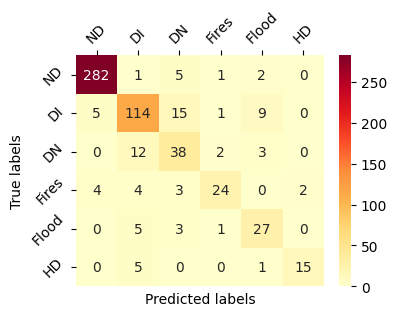

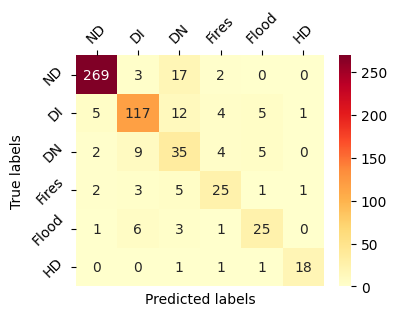

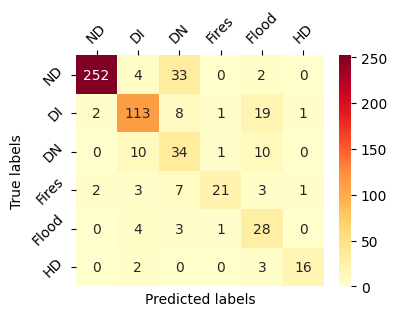

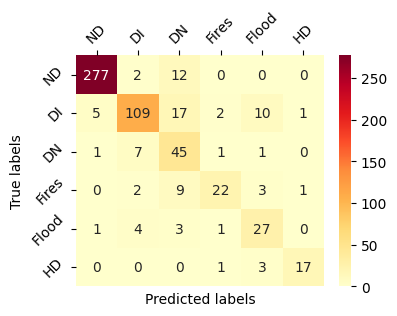

In [48]:
for i,model in enumerate(keras_embeddings_models):
  keras_embeddings_models_confusion_matrix(model,keras_embeddings_model_names[i])

## Textual Models (GLOVE Embeddings)

In [59]:
import numpy as np

# Replace this with the actual path where you have stored the GloVe embeddings file
pretrained_path = '/content/drive/MyDrive/pretrained_path'

def create_glove_embeddings():
    # Load the whole embedding into memory
    embeddings_index = dict()
    glove_file = pretrained_path + '/glove.840B.300d.txt'  # Path to GloVe embeddings

    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            try:
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
            except ValueError:
                # If a value can't be converted to float, skip this line
                continue

    print(f'Loaded {len(embeddings_index)} word vectors.')

    # Create a weight matrix for words in training docs
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

# Call the function
embedding_matrix = create_glove_embeddings()


Loaded 2195884 word vectors.


In [58]:
def create_glove_fastext_embeddings_models(max_len,embedding_matrix):

  ###### BiLSTM Model #######
  bi_text_inputs = Input(shape=(max_len,))
  bi_embedding_layer = Embedding(vocab_size,300, weights=[embedding_matrix], trainable=False)(bi_text_inputs)
  LSTM_Layer_1 = Bidirectional(LSTM(128,dropout=0.01))(bi_embedding_layer)
  bi_dense_layer_1 = Dense(6, activation='softmax')(LSTM_Layer_1)
  bilstm_model = Model(inputs=bi_text_inputs, outputs=bi_dense_layer_1)

  ##### CNN Model  #######
  cnn_text_inputs = Input(shape=(max_len,))
  cnn_embedding_layer = Embedding(vocab_size,300, weights=[embedding_matrix], trainable=False)(cnn_text_inputs)
  cnn_conv1 = Conv1D(128,2,activation='relu')(cnn_embedding_layer)
  cnn_pool1 = MaxPooling1D(2)(cnn_conv1)
  cnn_flat = Flatten()(cnn_pool1)
  cnn_dense_layer_1 = Dense(6, activation='softmax')(cnn_flat)
  cnn_model = Model(inputs=cnn_text_inputs, outputs=cnn_dense_layer_1)


  ##### LSTM-CNN Model ####
  lc_text_inputs = Input(shape=(max_len,))
  lc_embedding_layer = Embedding(vocab_size,300, weights=[embedding_matrix], trainable=False)(lc_text_inputs)
  LSTM_Layer = Bidirectional(LSTM(128,return_sequences=True,dropout=0.01))(lc_embedding_layer)
  lc_conv1 = Conv1D(128,2,activation='relu')(LSTM_Layer)
  lc_pool1 = MaxPooling1D(2)(lc_conv1)
  lc_flat = Flatten()(lc_pool1)
  lc_dense_layer_1 = Dense(6, activation='softmax')(lc_flat)
  cnn_lstm_model = Model(inputs=lc_text_inputs, outputs=lc_dense_layer_1)

  models = [bilstm_model,cnn_model, cnn_lstm_model]

  return models

In [52]:
model_name = ['glove_LSTM','glove_CNN','golve_LSTM_CNN']
list_model = create_glove_fastext_embeddings_models(150,embedding_matrix)

for mn,model in enumerate(list_model):
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(f"Model Name: {model_name[mn]}\n")
  model.fit(train_pad_sequences,
  y_train,
  epochs=30,
  batch_size =32,
  validation_split=0.1,
  verbose =1,
  callbacks = callbacks_check(model_name[mn]))

Model Name: glove_LSTM

Epoch 1/30
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6210 - loss: 1.0958
Epoch 1: val_accuracy improved from -inf to 0.79619, saving model to /content/drive/MyDrive/multimodal/Models/glove_LSTM.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6227 - loss: 1.0910 - val_accuracy: 0.7962 - val_loss: 0.6405
Epoch 2/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8206 - loss: 0.5292
Epoch 2: val_accuracy improved from 0.79619 to 0.82667, saving model to /content/drive/MyDrive/multimodal/Models/glove_LSTM.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8207 - loss: 0.5288 - val_accuracy: 0.8267 - val_loss: 0.5037
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8743 - loss: 0.3778
Epoch 3: val_accuracy did not improve from 0.82667
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8743 - loss: 0.3779 - val_accuracy: 0.8019 - val_loss: 0.5950
Epoch 4/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8775 - loss: 0.3570
Epoch 4: val_accuracy improved from 0.82667 to 0.83429, saving model to /content/drive/MyDrive/multimodal/Models/glove_LSTM.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8776 - loss: 0.3566 - val_accuracy: 0.8343 - val_loss: 0.4661
Epoch 5/30
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9011 - loss: 0.2906
Epoch 5: val_accuracy improved from 0.83429 to 0.85333, saving model to /content/drive/MyDrive/multimodal/Models/glove_LSTM.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9009 - loss: 0.2912 - val_accuracy: 0.8533 - val_loss: 0.4663
Epoch 6/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9189 - loss: 0.2492
Epoch 6: val_accuracy did not improve from 0.85333
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9188 - loss: 0.2492 - val_accuracy: 0.8419 - val_loss: 0.4766
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9222 - loss: 0.2276
Epoch 7: val_accuracy did not improve from 0.85333
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9222 - loss: 0.2276 - val_accuracy: 0.8438 - val_loss: 0.4976
Epoch 8/30
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9262 - loss: 0.2210
Epoch 8: val_accuracy did not improve from 0.85333
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9262 - loss: 0.2211 - val_accuracy: 0.8476 - val_loss: 0.5000
Epoch 9/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9426 - loss: 0.1816
Epoch 9: val_accuracy did n

148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5926 - loss: 1.1766 - val_accuracy: 0.7600 - val_loss: 0.6286
Epoch 2/30
144/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8529 - loss: 0.4340
Epoch 2: val_accuracy improved from 0.76000 to 0.80571, saving model to /content/drive/MyDrive/multimodal/Models/glove_CNN.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8533 - loss: 0.4329 - val_accuracy: 0.8057 - val_loss: 0.5498
Epoch 3/30
138/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9151 - loss: 0.2691
Epoch 3: val_accuracy improved from 0.80571 to 0.81143, saving model to /content/drive/MyDrive/multimodal/Models/glove_CNN.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9153 - loss: 0.2682 - val_accuracy: 0.8114 - val_loss: 0.5522
Epoch 4/30
144/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9516 - loss: 0.1715
Epoch 4: val_accuracy improved from 0.81143 to 0.81524, saving model to /content/drive/MyDrive/multimodal/Models/glove_CNN.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9515 - loss: 0.1716 - val_accuracy: 0.8152 - val_loss: 0.5607
Epoch 5/30
139/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9678 - loss: 0.1256
Epoch 5: val_accuracy improved from 0.81524 to 0.82857, saving model to /content/drive/MyDrive/multimodal/Models/glove_CNN.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9677 - loss: 0.1255 - val_accuracy: 0.8286 - val_loss: 0.5827
Epoch 6/30
143/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9802 - loss: 0.0876
Epoch 6: val_accuracy did not improve from 0.82857
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9801 - loss: 0.0878 - val_accuracy: 0.8229 - val_loss: 0.6221
Epoch 7/30
142/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.0712
Epoch 7: val_accuracy did not improve from 0.82857
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9829 - loss: 0.0713 - val_accuracy: 0.8248 - val_loss: 0.6465
Epoch 8/30
140/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9843 - loss: 0.0630
Epoch 8: val_accuracy did not improve from 0.82857
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9844 - loss: 0.0629 - val_accuracy: 0.8248 - val_loss: 0.6860
Epoch 9/30
141/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9888 - loss: 0.0429
Epoch 9: val_accuracy did not impro

148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6290 - loss: 1.0049 - val_accuracy: 0.7771 - val_loss: 0.6125
Epoch 2/30
145/148 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8401 - loss: 0.4802
Epoch 2: val_accuracy improved from 0.77714 to 0.84571, saving model to /content/drive/MyDrive/multimodal/Models/golve_LSTM_CNN.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8403 - loss: 0.4791 - val_accuracy: 0.8457 - val_loss: 0.4978
Epoch 3/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8842 - loss: 0.3287
Epoch 3: val_accuracy did not improve from 0.84571
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8842 - loss: 0.3286 - val_accuracy: 0.8400 - val_loss: 0.5011
Epoch 4/30
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9170 - loss: 0.2481
Epoch 4: val_accuracy did not improve from 0.84571
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9170 - loss: 0.2481 - val_accuracy: 0.8267 - val_loss: 0.5400
Epoch 5/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9330 - loss: 0.1935
Epoch 5: val_accuracy did not improve from 0.84571
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9330 - loss: 0.1935 - val_accuracy: 0.8362 - val_loss: 0.6001
Epoch 6/30
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9575 - loss: 0.1332
Epoch 6: val_accuracy did n

## LSTM + Attention (Glove)

In [57]:
keras.backend.clear_session()

def create_glove_fast_lstm_attention_model(model_name,embedding_matrix):

  filepath = dataset_root+ 'Models/'+ f'{model_name}.h5'
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max' )

  class Attention(tf.keras.Model):
      def __init__(self, units):
          super(Attention, self).__init__()
          self.W1 = tf.keras.layers.Dense(units)
          self.W2 = tf.keras.layers.Dense(units)
          self.V = tf.keras.layers.Dense(1)

      def call(self, features, hidden):
          # hidden shape == (batch_size, hidden size)
          # hidden_with_time_axis shape == (batch_size, 1, hidden size)
          # we are doing this to perform addition to calculate the score
          hidden_with_time_axis = tf.expand_dims(hidden, 1)

          # score shape == (batch_size, max_length, 1)
          # we get 1 at the last axis because we are applying score to self.V
          # the shape of the tensor before applying self.V is (batch_size, max_length, units)
          score = tf.nn.tanh(
              self.W1(features) + self.W2(hidden_with_time_axis))
          # attention_weights shape == (batch_size, max_length, 1)
          attention_weights = tf.nn.softmax(self.V(score), axis=1)

          # context_vector shape after sum == (batch_size, hidden_size)
          context_vector = attention_weights * features
          context_vector = tf.reduce_sum(context_vector, axis=1)
          return context_vector, attention_weights

  sequence_input = Input(shape=(150,), dtype="int32")
  embedded_sequences = Embedding(vocab_size,300, weights=[embedding_matrix], trainable=False)(sequence_input)
  lstm = Bidirectional(LSTM(128, return_sequences = True), name="bi_lstm_0")(embedded_sequences)
  # Getting our LSTM outputs
  (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(64, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

  state_h = Concatenate()([forward_h, backward_h])
  state_c = Concatenate()([forward_c, backward_c])
  context_vector, attention_weights = Attention(20)(lstm, state_h)
  dense1 = Dense(20, activation="relu")(context_vector)
  dropout = Dropout(0.01)(dense1)
  output = Dense(6, activation="softmax")(dropout)

  lstm_attention_model = Model(inputs=sequence_input, outputs=output)

  return lstm_attention_model,checkpoint


In [60]:
model, checkpoint = create_glove_fast_lstm_attention_model('glove_lstm_att', embedding_matrix)  # Unpack the tuple
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [55]:
model.fit(train_pad_sequences,y_train,
                    batch_size=32,
                    epochs=20,
                    validation_split=0.10,
                    verbose =1,
                    callbacks = [checkpoint] )

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5885 - loss: 1.1051
Epoch 1: val_accuracy improved from -inf to 0.78286, saving model to /content/drive/MyDrive/multimodal/Models/glove_lstm_att.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.5890 - loss: 1.1036 - val_accuracy: 0.7829 - val_loss: 0.6224
Epoch 2/20
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8344 - loss: 0.4969
Epoch 2: val_accuracy improved from 0.78286 to 0.82286, saving model to /content/drive/MyDrive/multimodal/Models/glove_lstm_att.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8346 - loss: 0.4963 - val_accuracy: 0.8229 - val_loss: 0.4543
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8943 - loss: 0.3224
Epoch 3: val_accuracy improved from 0.82286 to 0.84381, saving model to /content/drive/MyDrive/multimodal/Models/glove_lstm_att.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.8943 - loss: 0.3224 - val_accuracy: 0.8438 - val_loss: 0.4517
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9157 - loss: 0.2571
Epoch 4: val_accuracy improved from 0.84381 to 0.85524, saving model to /content/drive/MyDrive/multimodal/Models/glove_lstm_att.h5


148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9156 - loss: 0.2573 - val_accuracy: 0.8552 - val_loss: 0.4613
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9391 - loss: 0.1961
Epoch 5: val_accuracy did not improve from 0.85524
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9390 - loss: 0.1962 - val_accuracy: 0.8533 - val_loss: 0.4730
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9441 - loss: 0.1634
Epoch 6: val_accuracy did not improve from 0.85524
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9441 - loss: 0.1635 - val_accuracy: 0.8514 - val_loss: 0.5222
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9500 - loss: 0.1542
Epoch 7: val_accuracy did not improve from 0.85524
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9500 - loss: 0.1542 - val_accuracy: 0.8400 - val_loss: 0.5887
Epoch 8/20
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9604 - loss: 0.1192
Epoch 8: val_accuracy did 

## Models Performance (Glove Embeddings)

In [54]:
glove_embeddings_models = ['glove_LSTM','glove_CNN','golve_LSTM_CNN','glove_lstm_att']
golve_embeddings_model_names = ['LSTM','CNN','LSTM + CNN', 'LSTM + ATT']

def glove_embeddings_models_accuracy(saved_model):
  my_dict = {}
  # Prediction
  if saved_model == 'glove_lstm_att':
     model, _ = create_glove_fast_lstm_attention_model('glove_lstm_att', embedding_matrix) # Pass embedding_matrix here
    # Load the saved model
     model.load_weights(dataset_root+'Models/'+f"{saved_model}.h5")
     y_pred = np.argmax(model.predict(test_pad_sequences), axis=-1)
  else:
     model = load_model(dataset_root+'Models/'+f"{saved_model}.h5")
     y_pred = np.argmax(model.predict(test_pad_sequences), axis=-1)

  y_true = test_data['enc_label']

  my_dict['Accuracy'] = accuracy_score(y_true, y_pred)*100
  my_dict['Precision'] = precision_score(y_true, y_pred,average = 'weighted')*100
  my_dict['Recall'] = recall_score(y_true, y_pred,average = 'weighted')*100
  my_dict['F1 Score'] = f1_score(y_true, y_pred,average = 'weighted')*100
  return my_dict

In [61]:
accuracy = {f'{golve_embeddings_model_names[i]}':glove_embeddings_models_accuracy(model) for i,model in enumerate(glove_embeddings_models)}
# Save the performance parameter into json file
with open(dataset_root+'Results/'+'glove_embeddings_models_performance.json', 'w') as f:
    json.dump(accuracy, f)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step


In [58]:
# Load the json file
metrics = json.load(open(dataset_root+'Results/'+'glove_embeddings_models_performance.json'))
acc_list = []
pr_list = []
re_list = []
f1_list = []
for i in metrics.keys():
  acc_list.append(round(metrics[i]['Accuracy'],2))
  pr_list.append(round(metrics[i]['Precision'],2))
  re_list.append(round(metrics[i]['Recall'],2))
  f1_list.append(round(metrics[i]['F1 Score'],2))

print (color.BOLD+f"=======  Models (Glove) Performance on Test Data  =============\n"+color.END)
# Create a dataframe
performance_matrix = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list},
                                  index =['LSTM','CNN','LSTM + CNN','LSTM + Attn'])
performance_matrix

=======  Models (Glove) Performance on Test Data  =============



,Accuracy,Precision,Recall,F1 Score
LSTM,85.62,85.91,85.62,85.52
CNN,83.90,83.93,83.90,83.56
LSTM + CNN,82.19,83.38,82.19,81.84
LSTM + Attn,85.62,85.67,85.62,85.51


## Confusion Matrix (KE)

In [49]:
glove_embeddings_models = ['glove_LSTM','glove_CNN','golve_LSTM_CNN','glove_lstm_att']
golve_embeddings_model_names = ['LSTM','CNN','LSTM + CNN', 'LSTM + ATT']
class_names = ['ND','DI','DN','Fires','Flood','HD']
def glove_embeddings_models_confusion_matrix(saved_model,model_name):

    # Prediction
  if saved_model == 'glove_lstm_att':
     model, _ = create_glove_fast_lstm_attention_model(saved_model, embedding_matrix) # Pass embedding_matrix here
    # Load the saved model
     model.load_weights(dataset_root+'Models/'+f"{saved_model}.h5")
     y_pred = np.argmax(model.predict(test_pad_sequences), axis=-1)
  else:
    model = load_model(dataset_root+'Models/'+f"{saved_model}.h5")
    y_pred = np.argmax(model.predict(test_pad_sequences), axis=-1)

  y_true = test_data['enc_label']
  con_mat(y_true,y_pred,class_names,model_name)

======= Confusion Matrices for Glove Word Embeddings  =============



19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step


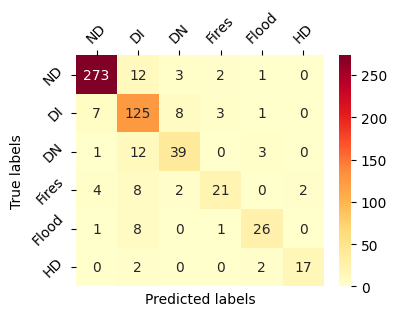

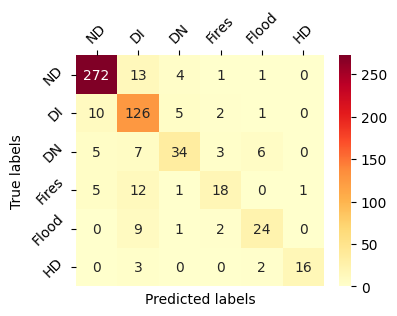

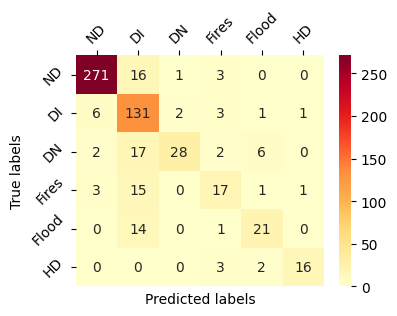

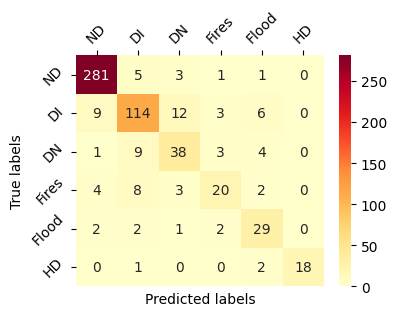

In [62]:
print (color.BOLD+f"======= Confusion Matrices for Glove Word Embeddings  =============\n"+color.END)
for i,model in enumerate(glove_embeddings_models):
  glove_embeddings_models_confusion_matrix(model,golve_embeddings_model_names[i])

In [63]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(train_data['enc_label'])
y_test=to_categorical(test_data['enc_label'])

In [64]:
y_train

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

#Visual Models

In [65]:
keras.backend.clear_session()

def visual_models():

  # create the base pre-trained model
  vgg = VGG16(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  for layer in vgg.layers[0:-10]:
      layer.trainable = False
  # add a global spatial average pooling layer
  x = vgg.output
  pool = GlobalAveragePooling2D()(x)
  # let's add a fully-connected layer
  #flat = Flatten()(pool)
  # and a logistic layer -- let's say we have 200 classes
  #hidden1 = Dense(512, activation='relu')(flat)
  #dropout = Dropout(0.1)(hidden1)
  output = Dense(6, activation='softmax')(pool)
  # this is the model we will train
  vgg_img_model = Model(inputs=vgg.input, outputs=output)

  #### Resnet
  resnet = ResNet50(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  #resnet.trainable = False
  for layer in resnet.layers[0:-10]:
      layer.trainable = False
  # add a global spatial average pooling layer
  y = resnet.output
  pool1 = GlobalAveragePooling2D()(y)
  # let's add a fully-connected layer
  #flat1 = Flatten()(pool1)
  # and a logistic layer -- let's say we have 200 classes
  #hidden = Dense(512, activation='relu')(flat1)
  #dropout1 = Dropout(0.1)(hidden)
  output1 = Dense(6, activation='softmax')(pool1)
  # this is the model we will train
  resnet_img_model = Model(inputs=resnet.input, outputs=output1)

  models = [vgg_img_model,resnet_img_model]

  return models


In [64]:
list_model = visual_models()
model = list_model[0]  # Only train VGG16 first

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00001),
    metrics=["accuracy"]
)

model.fit(
    x=train_image,
    y=y_train,
    epochs=30,
    batch_size=8,
    validation_split=0.1,
    verbose=1,
    callbacks=callbacks_check("vgg16")
)

# Clear memory before training the second model
import gc
keras.backend.clear_session()
gc.collect()

# Now train ResNet50
model = list_model[1]
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00001),
    metrics=["accuracy"]
)

model.fit(
    x=train_image,
    y=y_train,
    epochs=30,
    batch_size=8,
    validation_split=0.1,
    verbose=1,
    callbacks=callbacks_check("resnet")
)


Epoch 1/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5442 - loss: 2.0776
Epoch 1: val_accuracy improved from -inf to 0.73143, saving model to /content/drive/MyDrive/multimodal/Models/vgg16.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 70s 101ms/step - accuracy: 0.5444 - loss: 2.0761 - val_accuracy: 0.7314 - val_loss: 0.7751
Epoch 2/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8071 - loss: 0.5176
Epoch 2: val_accuracy improved from 0.73143 to 0.77333, saving model to /content/drive/MyDrive/multimodal/Models/vgg16.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 53s 90ms/step - accuracy: 0.8071 - loss: 0.5176 - val_accuracy: 0.7733 - val_loss: 0.6952
Epoch 3/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8901 - loss: 0.3156
Epoch 3: val_accuracy improved from 0.77333 to 0.79048, saving model to /content/drive/MyDrive/multimodal/Models/vgg16.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.8901 - loss: 0.3155 - val_accuracy: 0.7905 - val_loss: 0.7387
Epoch 4/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9369 - loss: 0.1778
Epoch 4: val_accuracy did not improve from 0.79048
591/591 ━━━━━━━━━━━━━━━━━━━━ 74s 77ms/step - accuracy: 0.9369 - loss: 0.1778 - val_accuracy: 0.7790 - val_loss: 0.9046
Epoch 5/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9747 - loss: 0.0858
Epoch 5: val_accuracy improved from 0.79048 to 0.80000, saving model to /content/drive/MyDrive/multimodal/Models/vgg16.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - accuracy: 0.9747 - loss: 0.0858 - val_accuracy: 0.8000 - val_loss: 0.8334
Epoch 6/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9905 - loss: 0.0416
Epoch 6: val_accuracy did not improve from 0.80000
591/591 ━━━━━━━━━━━━━━━━━━━━ 77s 77ms/step - accuracy: 0.9905 - loss: 0.0416 - val_accuracy: 0.7905 - val_loss: 1.0371
Epoch 7/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9883 - loss: 0.0478
Epoch 7: val_accuracy did not improve from 0.80000
591/591 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - accuracy: 0.9883 - loss: 0.0478 - val_accuracy: 0.7943 - val_loss: 1.0512
Epoch 8/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9929 - loss: 0.0300
Epoch 8: val_accuracy did not improve from 0.80000
591/591 ━━━━━━━━━━━━━━━━━━━━ 81s 77ms/step - accuracy: 0.9928 - loss: 0.0300 - val_accuracy: 0.7829 - val_loss: 0.9745
Epoch 9/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9890 - loss: 0.0379
Epoch 9: val_accuracy i

591/591 ━━━━━━━━━━━━━━━━━━━━ 88s 87ms/step - accuracy: 0.9890 - loss: 0.0379 - val_accuracy: 0.8114 - val_loss: 0.9845
Epoch 10/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9961 - loss: 0.0198
Epoch 10: val_accuracy did not improve from 0.81143
591/591 ━━━━━━━━━━━━━━━━━━━━ 46s 78ms/step - accuracy: 0.9961 - loss: 0.0199 - val_accuracy: 0.7962 - val_loss: 1.1584
Epoch 11/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9942 - loss: 0.0242
Reached 99.00% accuracy so we will stop trianing

Epoch 11: val_accuracy improved from 0.81143 to 0.82476, saving model to /content/drive/MyDrive/multimodal/Models/vgg16.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9942 - loss: 0.0242 - val_accuracy: 0.8248 - val_loss: 1.1425
Epoch 1/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4142 - loss: 1.5167
Epoch 1: val_accuracy improved from -inf to 0.72000, saving model to /content/drive/MyDrive/multimodal/Models/resnet.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 52s 60ms/step - accuracy: 0.4145 - loss: 1.5162 - val_accuracy: 0.7200 - val_loss: 0.8447
Epoch 2/30
589/591 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7284 - loss: 0.7395
Epoch 2: val_accuracy improved from 0.72000 to 0.78476, saving model to /content/drive/MyDrive/multimodal/Models/resnet.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 62s 37ms/step - accuracy: 0.7285 - loss: 0.7393 - val_accuracy: 0.7848 - val_loss: 0.7032
Epoch 3/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8048 - loss: 0.5516
Epoch 3: val_accuracy improved from 0.78476 to 0.80190, saving model to /content/drive/MyDrive/multimodal/Models/resnet.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.8048 - loss: 0.5515 - val_accuracy: 0.8019 - val_loss: 0.6375
Epoch 4/30
589/591 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8414 - loss: 0.4535
Epoch 4: val_accuracy improved from 0.80190 to 0.80381, saving model to /content/drive/MyDrive/multimodal/Models/resnet.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8415 - loss: 0.4534 - val_accuracy: 0.8038 - val_loss: 0.6287
Epoch 5/30
589/591 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8831 - loss: 0.3540
Epoch 5: val_accuracy improved from 0.80381 to 0.81333, saving model to /content/drive/MyDrive/multimodal/Models/resnet.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.8831 - loss: 0.3540 - val_accuracy: 0.8133 - val_loss: 0.6170
Epoch 6/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9041 - loss: 0.3004
Epoch 6: val_accuracy did not improve from 0.81333
591/591 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.9041 - loss: 0.3004 - val_accuracy: 0.8076 - val_loss: 0.6095
Epoch 7/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9312 - loss: 0.2454
Epoch 7: val_accuracy did not improve from 0.81333
591/591 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9312 - loss: 0.2454 - val_accuracy: 0.8038 - val_loss: 0.6189
Epoch 8/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9397 - loss: 0.2087
Epoch 8: val_accuracy did not improve from 0.81333
591/591 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9397 - loss: 0.2087 - val_accuracy: 0.8114 - val_loss: 0.6380
Epoch 9/30
589/591 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9586 - loss: 0.1685
Epoch 9: val_accuracy d

In [65]:
### Inception V3
def inception_model():
# create the base pre-trained model
  inception = keras.applications.InceptionV3(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
# for layer in inception.layers[0:-10]:
#     layer.trainable = False
  # add a global spatial average pooling layer
  x = inception.output
  pool = GlobalAveragePooling2D()(x)
  output = Dense(6, activation='softmax')(pool)
  # this is the model we will train
  inception_img_model = Model(inputs=inception.input, outputs=output)
  return inception_img_model

In [69]:
keras.backend.clear_session()
inception_img_model = inception_model()
inception_img_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=RMSprop(learning_rate=4e-5),
                      metrics = ["accuracy"])
  # Training model
inception_img_model.fit(x=train_image,
              y=train_data['enc_label'],
              epochs=30,
              batch_size =8,
              validation_split = 0.1,
              verbose = 1,
              callbacks = callbacks_check('inception')
              )

Epoch 1/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5951 - loss: 1.1160
Epoch 1: val_accuracy improved from -inf to 0.74095, saving model to /content/drive/MyDrive/multimodal/Models/inception.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 136s 120ms/step - accuracy: 0.5952 - loss: 1.1156 - val_accuracy: 0.7410 - val_loss: 0.9592
Epoch 2/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7614 - loss: 0.6355
Epoch 2: val_accuracy improved from 0.74095 to 0.76952, saving model to /content/drive/MyDrive/multimodal/Models/inception.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - accuracy: 0.7615 - loss: 0.6355 - val_accuracy: 0.7695 - val_loss: 0.8670
Epoch 3/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8338 - loss: 0.4522
Epoch 3: val_accuracy improved from 0.76952 to 0.79429, saving model to /content/drive/MyDrive/multimodal/Models/inception.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 48s 69ms/step - accuracy: 0.8338 - loss: 0.4522 - val_accuracy: 0.7943 - val_loss: 0.8516
Epoch 4/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8580 - loss: 0.3943
Epoch 4: val_accuracy did not improve from 0.79429
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.8581 - loss: 0.3943 - val_accuracy: 0.7867 - val_loss: 1.0344
Epoch 5/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8988 - loss: 0.2834
Epoch 5: val_accuracy did not improve from 0.79429
591/591 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.8988 - loss: 0.2834 - val_accuracy: 0.7562 - val_loss: 1.1999
Epoch 6/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9277 - loss: 0.2252
Epoch 6: val_accuracy did not improve from 0.79429
591/591 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.9277 - loss: 0.2252 - val_accuracy: 0.7676 - val_loss: 1.4024
Epoch 7/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9410 - loss: 0.1703
Epoch 7: val_accuracy d

In [66]:
model = load_model(dataset_root+'Models/'+"inception.h5")
y_pred = np.argmax(model.predict(test_image), axis=-1)

y_true = test_data['enc_label']

print_metrices(y_true,y_pred)


19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step
[[275   7   5   2   2   0]
 [ 24 104   9   1   3   3]
 [  7  14  29   1   3   1]
 [  8   2   2  25   0   0]
 [  8   3   1   0  24   0]
 [  9   1   0   0   1  10]]
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       291
           1       0.79      0.72      0.76       144
           2       0.63      0.53      0.57        55
           3       0.86      0.68      0.76        37
           4       0.73      0.67      0.70        36
           5       0.71      0.48      0.57        21

    accuracy                           0.80       584
   macro avg       0.76      0.67      0.71       584
weighted avg       0.79      0.80      0.79       584

Accuracy :  0.7996575342465754
Precison :  0.7942470295165509
Recall :  0.7996575342465754
F1 :  0.7926188628143335


## Visual Models Performance

In [67]:
visual_models = ['vgg16','resnet']
visual_model_names = ['VGG19','ResNet']

def visual_models_accuracy(saved_model):
  my_dict = {}
  # Prediction
  model = load_model(dataset_root+'Models/'+f"{saved_model}.h5")
  y_pred = np.argmax(model.predict(test_image), axis=-1)

  y_true = test_data['enc_label']

  my_dict['Accuracy'] = accuracy_score(y_true, y_pred)*100
  my_dict['Precision'] = precision_score(y_true, y_pred,average = 'weighted')*100
  my_dict['Recall'] = recall_score(y_true, y_pred,average = 'weighted')*100
  my_dict['F1 Score'] = f1_score(y_true, y_pred,average = 'weighted')*100
  return my_dict

In [68]:
accuracy = {f'{visual_model_names[i]}':visual_models_accuracy(model) for i,model in enumerate(visual_models)}
# Save the performance parameter into json file
with open(dataset_root+'Results/'+'visual_models_performance.json', 'w') as f:
    json.dump(accuracy, f)

19/19 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step


19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step


In [69]:
# Load the json file
metrics = json.load(open(dataset_root+'Results/'+'visual_models_performance.json'))
acc_list = []
pr_list = []
re_list = []
f1_list = []
for i in metrics.keys():
  acc_list.append(round(metrics[i]['Accuracy'],2))
  pr_list.append(round(metrics[i]['Precision'],2))
  re_list.append(round(metrics[i]['Recall'],2))
  f1_list.append(round(metrics[i]['F1 Score'],2))

print (color.BOLD+f"=======  Visual Models Performance on Test Data  =============\n"+color.END)
# Create a dataframe
performance_matrix = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list},
                                  index =['VGG19','ResNet'])
performance_matrix

=======  Visual Models Performance on Test Data  =============



,Accuracy,Precision,Recall,F1 Score
VGG19,80.82,80.92,80.82,80.67
ResNet,81.85,81.85,81.85,81.76


## Confusion Matrix (Visual Models)

In [70]:
visual_models = ['vgg16','resnet']
visual_model_names = ['VGG16','ResNet']
class_names = ['ND','DI','DN','Fires','Flood','HD']
def visual_models_confusion_matrix(saved_model,model_name):

  model = load_model(dataset_root+'Models/'+f"{saved_model}.h5")
  y_pred = np.argmax(model.predict(test_image), axis=-1)

  y_true = test_data['enc_label']
  con_mat(y_true,y_pred,class_names,model_name)

======= Confusion Matrices for Visual Models  =============



19/19 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step


19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step


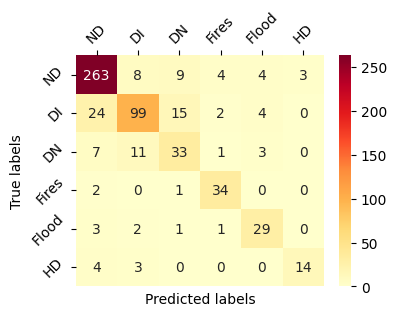

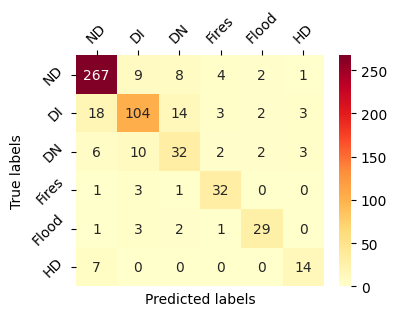

In [71]:
print (color.BOLD+f"======= Confusion Matrices for Visual Models  =============\n"+color.END)
for i,model in enumerate(visual_models):
  visual_models_confusion_matrix(model,visual_model_names[i])

## Multimodal Models (LSTM-ATTN + VGG16 )

In [2]:
import tensorflow.keras as keras #Importing tensorflow.keras
import tensorflow as tf

keras.backend.clear_session()
def create_lstm_attention_vgg16_model ():

  # create the base pre-trained model
  vgg = keras.applications.VGG16(weights='imagenet', include_top=False,input_shape=(150, 150, 3)) #Using keras here
  for layer in vgg.layers[0:-10]:
      layer.trainable = False
  # add a global spatial average pooling layer
  x = vgg.output
  pool = keras.layers.GlobalAveragePooling2D()(x) #Using keras here
  # let's add a fully-connected layer
  flat = keras.layers.Flatten()(pool) #Using keras here
  # and a logistic layer -- let's say we have 200 classes
  #hidden1 = Dense(512, activation='relu')(flat)
  #dropout = Dropout(0.1)(hidden1)
  hidden2 = keras.layers.Dense(200, activation='relu')(flat) #Using keras here
  #output = Dense(6, activation='softmax')(dropout)
  # this is the model we will train
  vgg_img_model = keras.models.Model(inputs=vgg.input, outputs=hidden2) #Using keras here


  # Text Model

  class Attention(tf.keras.Model):
      def __init__(self, units):
          super(Attention, self).__init__()
          self.W1 = tf.keras.layers.Dense(units)
          self.W2 = tf.keras.layers.Dense(units)
          self.V = tf.keras.layers.Dense(1)

      def call(self, features, hidden):
          # hidden shape == (batch_size, hidden size)
          # hidden_with_time_axis shape == (batch_size, 1, hidden size)
          # we are doing this to perform addition to calculate the score
          hidden_with_time_axis = tf.expand_dims(hidden, 1)

          # score shape == (batch_size, max_length, 1)
          # we get 1 at the last axis because we are applying score to self.V
          # the shape of the tensor before applying self.V is (batch_size, max_length, units)
          score = tf.nn.tanh(
              self.W1(features) + self.W2(hidden_with_time_axis))
          # attention_weights shape == (batch_size, max_length, 1)
          attention_weights = tf.nn.softmax(self.V(score), axis=1)

          # context_vector shape after sum == (batch_size, hidden_size)
          context_vector = attention_weights * features
          context_vector = tf.reduce_sum(context_vector, axis=1)
          return context_vector, attention_weights

  sequence_input = keras.Input(shape=(150,), dtype="int32") #Using keras here
  embedded_sequences = keras.layers.Embedding(vocab_size, 100)(sequence_input) #Using keras here
  lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences = True,dropout=0.01), name="bi_lstm_0")(embedded_sequences) #Using keras here
  # Getting our LSTM outputs
  (lstm, forward_h, forward_c, backward_h, backward_c) = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm) #Using keras here

  state_h = keras.layers.Concatenate()([forward_h, backward_h]) #Using keras here
  state_c = keras.layers.Concatenate()([forward_c, backward_c]) #Using keras here
  context_vector, attention_weights = Attention(20)(lstm, state_h)
  dense1 = keras.layers.Dense(200, activation="relu")(context_vector) #Using keras here
  #dropout = Dropout(0.01)(dense1)
  #output = Dense(6, activation="softmax")(dropout)

  lstm_attention_model = keras.models.Model(inputs=sequence_input, outputs=dense1) #Using keras here

  # Concatenating the output of 2 classifiers
  con_layer = keras.layers.concatenate([vgg_img_model.output, lstm_attention_model.output]) #Using keras here
  dropout = keras.layers.Dropout(0.2)(con_layer) #Using keras here
  out = keras.layers.Dense(6,activation='softmax')(dropout) #Using keras here

  #Defining model input and output
  com_model = keras.models.Model(inputs = [vgg_img_model.input, lstm_attention_model.input], outputs=out) #Using keras here

  return com_model

In [73]:
filepath = dataset_root+ 'Models/'+ 'vgg_lstm_att-3.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max' )

In [74]:
model = create_lstm_attention_vgg16_model()
# Plot model
#plot_model(model, to_file='Two_LSTM_Inception_mul_model.png', show_shapes=True, show_layer_names=True)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [78]:
model.compile(loss='categorical_crossentropy',
                      optimizer=RMSprop(),
                      metrics = ["accuracy"])

Adam(learning_rate=.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [1]:
model.fit([train_image,train_pad_sequences],
          y_train,
          batch_size=64,
          epochs=50,
          validation_split=0.10,
          verbose =1,
          callbacks = [checkpoint] )

NameError: name 'model' is not defined

In [ ]:
model = create_lstm_attention_vgg16_model()
# Load the saved model
model.load_weights(folder_path+'Models/'+'vgg_lstm_att-3.h5')
y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)
print_metrices(test_data['enc_label'],y_pred)

[[284   4   1   0   0   2]
 [  6 124   5   1   6   2]
 [  0   9  41   2   3   0]
 [  5   3   3  21   2   3]
 [  0   1   2   1  32   0]
 [  0   0   0   0   1  20]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       291
           1       0.88      0.86      0.87       144
           2       0.79      0.75      0.77        55
           3       0.84      0.57      0.68        37
           4       0.73      0.89      0.80        36
           5       0.74      0.95      0.83        21

    accuracy                           0.89       584
   macro avg       0.82      0.83      0.82       584
weighted avg       0.90      0.89      0.89       584

Accuracy :  0.8938356164383562
Precison :  0.8954969328210132
Recall :  0.8938356164383562
F1 :  0.8919190846649082


## Multimodal Models (LSTM-ATTN + ResNet )

In [ ]:
def create_lstm_attention_resnet_model ():
  keras.backend.clear_session()
  # create the base pre-trained model
  resnet = ResNet50(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  for layer in resnet.layers[0:-10]:
      layer.trainable = False
  # add a global spatial average pooling layer
  x = resnet.output
  pool = GlobalAveragePooling2D()(x)
  # let's add a fully-connected layer
  flat = Flatten()(pool)
  # and a logistic layer -- let's say we have 200 classes
  hidden2 = Dense(200, activation='relu')(flat)
  # this is the model we will train
  resnet_img_model = Model(inputs=resnet.input, outputs=hidden2)


  # Text Model

  class Attention(tf.keras.Model):
      def __init__(self, units):
          super(Attention, self).__init__()
          self.W1 = tf.keras.layers.Dense(units)
          self.W2 = tf.keras.layers.Dense(units)
          self.V = tf.keras.layers.Dense(1)

      def call(self, features, hidden):
          # hidden shape == (batch_size, hidden size)
          # hidden_with_time_axis shape == (batch_size, 1, hidden size)
          # we are doing this to perform addition to calculate the score
          hidden_with_time_axis = tf.expand_dims(hidden, 1)

          # score shape == (batch_size, max_length, 1)
          # we get 1 at the last axis because we are applying score to self.V
          # the shape of the tensor before applying self.V is (batch_size, max_length, units)
          score = tf.nn.tanh(
              self.W1(features) + self.W2(hidden_with_time_axis))
          # attention_weights shape == (batch_size, max_length, 1)
          attention_weights = tf.nn.softmax(self.V(score), axis=1)

          # context_vector shape after sum == (batch_size, hidden_size)
          context_vector = attention_weights * features
          context_vector = tf.reduce_sum(context_vector, axis=1)
          return context_vector, attention_weights

  sequence_input = Input(shape=(150,), dtype="int32")
  embedded_sequences = Embedding(vocab_size, 100)(sequence_input)
  lstm = Bidirectional(LSTM(128, return_sequences = True,dropout=0.01), name="bi_lstm_0")(embedded_sequences)
  # Getting our LSTM outputs
  (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(64, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

  state_h = Concatenate()([forward_h, backward_h])
  state_c = Concatenate()([forward_c, backward_c])
  context_vector, attention_weights = Attention(20)(lstm, state_h)
  dense1 = Dense(200, activation="relu")(context_vector)


  lstm_attention_model = Model(inputs=sequence_input, outputs=dense1)

  # Concatenating the output of 2 classifiers
  con_layer = keras.layers.concatenate([resnet_img_model.output, lstm_attention_model.output])
  dropout = Dropout(0.2)(con_layer)
  final_dense = Dense(64, activation="relu")(dropout)
  out = Dense(6,activation='softmax')(final_dense)

  #Defining model input and output
  com_model = Model(inputs = [resnet_img_model.input, lstm_attention_model.input], outputs=out)

  return com_model


In [ ]:
filepath = folder_path+ 'Models/'+ 'resnet_lstm_att.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=True, mode='max' )

In [ ]:
model = create_lstm_attention_resnet_model()
# Plot model
#plot_model(model, to_file='Two_LSTM_Inception_mul_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics = ["accuracy"])
# Learning Rate --> 3e-3

#Adam(lr=3e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model.fit([train_image,train_pad_sequences],
          y_train,
          batch_size=64,
          epochs=50,
          validation_split=0.10,
          verbose =1,
          callbacks = [checkpoint] )

In [ ]:
model = create_lstm_attention_resnet_model()
# Load the saved model
model.load_weights(folder_path+'Models/'+'resnet_lstm_att.h5')
y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)
print_metrices(test_data['enc_label'],y_pred)

[[283   3   1   3   1   0]
 [  3 126   8   3   4   0]
 [  0  11  43   0   1   0]
 [  0   1   1  35   0   0]
 [  0   5   0   0  31   0]
 [  0   0   0   0   1  20]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       291
           1       0.86      0.88      0.87       144
           2       0.81      0.78      0.80        55
           3       0.85      0.95      0.90        37
           4       0.82      0.86      0.84        36
           5       1.00      0.95      0.98        21

    accuracy                           0.92       584
   macro avg       0.89      0.90      0.89       584
weighted avg       0.92      0.92      0.92       584

Accuracy :  0.9212328767123288
Precison :  0.922599235387014
Recall :  0.9212328767123288
F1 :  0.9216348727952666


## Multimodal Models (LSTM-ATTN + Inception )

In [ ]:
def create_lstm_attention_inception_model ():
  keras.backend.clear_session()
  # create the base pre-trained model
  inception = keras.applications.InceptionV3(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
# for layer in inception.layers[0:-10]:
#     layer.trainable = False
  # add a global spatial average pooling layer
  x = inception.output
  pool = GlobalAveragePooling2D()(x)
  # this is the model we will train
  flat = Flatten()(pool)
  # and a logistic layer -- let's say we have 200 classes
  hidden2 = Dense(200, activation='relu')(flat)
  # this is the model we will train
  inception_img_model = Model(inputs=inception.input, outputs=hidden2)


  # Text Model

  class Attention(tf.keras.Model):
      def __init__(self, units):
          super(Attention, self).__init__()
          self.W1 = tf.keras.layers.Dense(units)
          self.W2 = tf.keras.layers.Dense(units)
          self.V = tf.keras.layers.Dense(1)

      def call(self, features, hidden):
          # hidden shape == (batch_size, hidden size)
          # hidden_with_time_axis shape == (batch_size, 1, hidden size)
          # we are doing this to perform addition to calculate the score
          hidden_with_time_axis = tf.expand_dims(hidden, 1)

          # score shape == (batch_size, max_length, 1)
          # we get 1 at the last axis because we are applying score to self.V
          # the shape of the tensor before applying self.V is (batch_size, max_length, units)
          score = tf.nn.tanh(
              self.W1(features) + self.W2(hidden_with_time_axis))
          # attention_weights shape == (batch_size, max_length, 1)
          attention_weights = tf.nn.softmax(self.V(score), axis=1)

          # context_vector shape after sum == (batch_size, hidden_size)
          context_vector = attention_weights * features
          context_vector = tf.reduce_sum(context_vector, axis=1)
          return context_vector, attention_weights

  sequence_input = Input(shape=(150,), dtype="int32")
  embedded_sequences = Embedding(vocab_size, 100)(sequence_input)
  lstm = Bidirectional(LSTM(128, return_sequences = True,dropout=0.01), name="bi_lstm_0")(embedded_sequences)
  # Getting our LSTM outputs
  (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(64, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

  state_h = Concatenate()([forward_h, backward_h])
  state_c = Concatenate()([forward_c, backward_c])
  context_vector, attention_weights = Attention(20)(lstm, state_h)
  dense1 = Dense(200, activation="relu")(context_vector)


  lstm_attention_model = Model(inputs=sequence_input, outputs=dense1)

  # Concatenating the output of 2 classifiers
  con_layer = keras.layers.concatenate([inception_img_model.output, lstm_attention_model.output])
  dropout = Dropout(0.2)(con_layer)
  final_dense = Dense(64, activation="relu")(dropout)
  out = Dense(6,activation='softmax')(final_dense)

  #Defining model input and output
  com_model = Model(inputs = [inception_img_model.input, lstm_attention_model.input], outputs=out)

  return com_model


In [ ]:
filepath = folder_path+ 'Models/'+ 'inception_lstm_att.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=True, mode='max' )

In [ ]:
model = create_lstm_attention_inception_model()
# Plot model
#plot_model(model, to_file='Two_LSTM_Inception_mul_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics = ["accuracy"])
# Learning Rate --> 3e-3

#Adam(lr=3e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model.fit([train_image,train_pad_sequences],
          y_train,
          batch_size=64,
          epochs=50,
          validation_split=0.10,
          verbose =1,
          callbacks = [checkpoint] )

In [ ]:
model = create_lstm_attention_inception_model()
# Load the saved model
model.load_weights(folder_path+'Models/'+'inception_lstm_att.h5')
y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)
print_metrices(test_data['enc_label'],y_pred)

[[273  10   2   2   4   0]
 [  9 117   5   6   7   0]
 [  1  13  29   4   8   0]
 [ 17   3   0  17   0   0]
 [  3   4   1   4  24   0]
 [  1   4   0   3   1  12]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       291
           1       0.77      0.81      0.79       144
           2       0.78      0.53      0.63        55
           3       0.47      0.46      0.47        37
           4       0.55      0.67      0.60        36
           5       1.00      0.57      0.73        21

    accuracy                           0.81       584
   macro avg       0.75      0.66      0.69       584
weighted avg       0.81      0.81      0.80       584

Accuracy :  0.8082191780821918
Precison :  0.8118467650716236
Recall :  0.8082191780821918
F1 :  0.8048605136296929


## Multimodal Models

In [ ]:
visual_model_name = ['vgg16','resnet']
visual_models_lsit = visual_models()

textual_model_name = ['LSTM','CNN']
text_models_list = create_keras_embeddings_models(150)


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
for vm,visual_model in enumerate(visual_models_lsit):
  for tm,textual_model in enumerate(text_models_list[:-1]):
    # Concatenating the output of 2 classifiers
    con_layer = keras.layers.concatenate([visual_model.output, textual_model.output])
    dropout = Dropout(0.2)(con_layer)
    final_dense = Dense(64, activation="relu")(dropout)
    out = Dense(6,activation='softmax')(final_dense)

    #Defining model input and output
    com_model = Model(inputs = [visual_model.input, textual_model.input], outputs=out)
    if visual_model == 'vgg16':
      opt = RMSprop()
    else:
      opt = Adam()

    com_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ["accuracy"])
    print(f"Model Name: {visual_model_name[vm]}+{textual_model_name[tm]}\n")
    com_model.fit([train_image,train_pad_sequences],
    y_train,
    epochs=50,
    batch_size =64,
    validation_split=0.1,
    verbose =1,
    callbacks = callbacks_check(visual_model_name[vm]+textual_model_name[tm]))

## Multimodal Models Performance

In [ ]:
multimodal_models = ['vgg16LSTM','vgg16CNN','resnetLSTM','resnetCNN']
multimodal_names =  ['VGG16+LSTM','VGG16+CNNText','ResNet+LSTM','ResNet+CNNText']

def multimodal_models_accuracy(saved_model):
  my_dict = {}
  # Prediction
  model = load_model(folder_path+'Models/'+f"{saved_model}.h5")
  y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

  y_true = test_data['enc_label']

  my_dict['Accuracy'] = accuracy_score(y_true, y_pred)*100
  my_dict['Precision'] = precision_score(y_true, y_pred,average = 'weighted')*100
  my_dict['Recall'] = recall_score(y_true, y_pred,average = 'weighted')*100
  my_dict['F1 Score'] = f1_score(y_true, y_pred,average = 'weighted')*100
  return my_dict

In [ ]:
accuracy = {f'{multimodal_names[i]}':multimodal_models_accuracy(model) for i,model in enumerate(multimodal_models)}
# Save the performance parameter into json file
with open(folder_path+'Results/'+'multimodal_models_performance.json', 'w') as f:
    json.dump(accuracy, f)

In [ ]:
# Load the json file
metrics = json.load(open(folder_path+'Results/'+'multimodal_models_performance.json'))
acc_list = []
pr_list = []
re_list = []
f1_list = []
for i in metrics.keys():
  acc_list.append(round(metrics[i]['Accuracy'],2))
  pr_list.append(round(metrics[i]['Precision'],2))
  re_list.append(round(metrics[i]['Recall'],2))
  f1_list.append(round(metrics[i]['F1 Score'],2))

print (color.BOLD+f"=======  Multimodal Models Performance on Test Data  =============\n"+color.END)
# Create a dataframe
performance_matrix = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list},
                                  index =multimodal_names)
performance_matrix

=======  Multimodal Models Performance on Test Data  =============



,Accuracy,Precision,Recall,F1 Score
VGG16+LSTM,76.20,81.98,76.20,78.14
VGG16+CNNText,73.46,74.39,73.46,72.57
ResNet+LSTM,81.34,84.22,81.34,81.90
ResNet+CNNText,78.42,77.68,78.42,77.45


In [ ]:
text_models_list

In [ ]:
### Multimodal models with Inception

visual_model_name = ['inception']
visual_models_list = [inception_model()]

textual_model_name = ['LSTM','CNN', 'LSTM-CNN']
text_models_list = create_keras_embeddings_models(150)

keras.backend.clear_session()

# for vm,visual_model in enumerate(visual_models_list):
#   for tm,textual_model in enumerate(text_models_list):
#     # Concatenating the output of 2 classifiers
#     con_layer = keras.layers.concatenate([visual_model.output, textual_model.output])
#     #dropout = Dropout(0.2)(con_layer)
#     #final_dense = Dense(64, activation="relu")(dropout)
#     out = Dense(6,activation='softmax')(con_layer)

#     #Defining model input and output
#     com_model = Model(inputs = [visual_model.input, textual_model.input], outputs=out)

#     com_model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(), metrics = ["accuracy"])
#     print(f"Model Name: {visual_model_name[vm]}+{textual_model_name[tm]}\n")
#     com_model.fit([train_image,train_pad_sequences],
#     train_data['enc_label'],
#     epochs=50,
#     batch_size =64,
#     validation_split=0.1,
#     verbose =1,
#     callbacks = callbacks_check(visual_model_name[vm] + textual_model_name[tm]))


visual_model = inception_model()
textual_model = text_models_list[2]

# Concatenating the output of 2 classifiers
con_layer = keras.layers.concatenate([visual_model.output, textual_model.output])
#dropout = Dropout(0.2)(con_layer)
#final_dense = Dense(64, activation="relu")(dropout)
out = Dense(6,activation='softmax')(con_layer)

    #Defining model input and output
com_model = Model(inputs = [visual_model.input, textual_model.input], outputs=out)

com_model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(), metrics = ["accuracy"])
    #print(f"Model Name: {visual_model_name[vm]}+{textual_model_name[tm]}\n")
com_model.fit([train_image,train_pad_sequences],
  train_data['enc_label'],
    epochs=50,
    batch_size =64,
    validation_split=0.1,
    verbose =1,
    callbacks = callbacks_check('inception+bilstm-CNN'))


In [ ]:
model = load_model(folder_path+'Models/'+"inception+CNN.h5")
y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

y_true = test_data['enc_label']

print_metrices(y_true,y_pred)

[[271  12   1   0   7   0]
 [  8 117   3   1   9   6]
 [  4  27  12   0  11   1]
 [  3   2   0  26   5   1]
 [  2   7   4   0  23   0]
 [  0   1   0   6   1  13]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       291
           1       0.70      0.81      0.75       144
           2       0.60      0.22      0.32        55
           3       0.79      0.70      0.74        37
           4       0.41      0.64      0.50        36
           5       0.62      0.62      0.62        21

    accuracy                           0.79       584
   macro avg       0.68      0.65      0.65       584
weighted avg       0.80      0.79      0.78       584

Accuracy :  0.791095890410959
Precison :  0.7966680171361482
Recall :  0.791095890410959
F1 :  0.7828538245838748


### Helper Functions

In [ ]:
def validacc_list(results):
  adam_acc = results['Adam']
  rmsprop_acc = results['RMSProp']
  nadam_acc = results['Nadam']
  return adam_acc,rmsprop_acc,nadam_acc


                     # ================================================================
                      ############################## For Ploting ########################
                      # ================================================================
def learning_rate_plot(range,adam,rmsprop,nadam,
                     x_label,title,x_lim,y_lim):
  sns.set()
  sns.set_style('white')

  plt.figure(figsize=(7,5))
  # x axis values
  x = range
  # corresponding y axis values
  y1 = adam
  # corresponding y axis values
  y2 = rmsprop
  y3 = nadam

  # plotting the points
  plt.plot(x, y1, color='darkred', linewidth = 3,
          marker='o', markersize=8)
  plt.plot(x, y2, color='dodgerblue',  linewidth = 3,
          marker='o', markersize=8)
  plt.plot(x, y3, color='seagreen',  linewidth = 3,
          marker='o', markersize=8)
  # plt.plot(x, y4, color='mediumvioletred', linewidth = 3,
  #         marker='o', markersize=8)
  plt.xscale('log')  # use only for learning rate
  plt.xticks(x,['6e-2','3e-2','1e-2','6e-3','3e-3','1e-3',
            '6e-4','3e-4','1e-4','6e-5','3e-5','1e-5'] ,rotation = '45')


  # setting x and y axis range
  plt.xlim(x_lim)
  plt.ylim(y_lim)


  # naming the x axis
  plt.xlabel(x_label,fontsize=10)
  # naming the y axis
  plt.ylabel('Validation Accuracy (Max.)',fontsize=10)

  plt.title(title,fontsize=10)
  plt.legend(["Adam", "RMSProp","Nadam"],loc = "upper right")
  plt.savefig(folder_path+'optimizer.png',dpi = 1000,bbox_inches ='tight')

## Learning Rate Tunning

In [ ]:
def lr_tunning(lr_rate):

  ## Optimizer Lists
  optimizer_name = ['Adam','RMSProp','Nadam']
  optimizer_list = [Adam(lr=lr_rate),RMSprop(lr=lr_rate),Nadam(lr=lr_rate)]

  # Callback
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=15)

  my_dict = {}
  for on,opt in enumerate(optimizer_list):
    model = create_lstm_attention_resnet_model()
    model.compile(loss='categorical_crossentropy',
                      optimizer=opt,
                      metrics = ["accuracy"]),
    print(f"Optimizer Name: {optimizer_name[on]} ===> Learning Rate : {lr_rate}")
    history = model.fit([train_image,train_pad_sequences],
    y_train,
    batch_size=64,
    epochs=50,
    validation_split=0.10,
    verbose =1,
    callbacks = [callback] )

    my_dict[optimizer_name[on]] = max(history.history['val_accuracy'])
  return  my_dict



In [ ]:
######### calling Function
lr_range = [0.06,0.03,0.01,0.006,0.003,0.001,
            0.0006,0.0003,0.0001,0.00006,0.00003,0.00001]
results = {f'Learning Rate: {i}':lr_tunning(i) for i in lr_range}

######## Save this result into a json file to avoid repeated running
with open(folder_path+'Results/'+'learning_rate.json', 'w') as f:
    json.dump(results, f)

## Learning Rate Vs Optimizer Plot

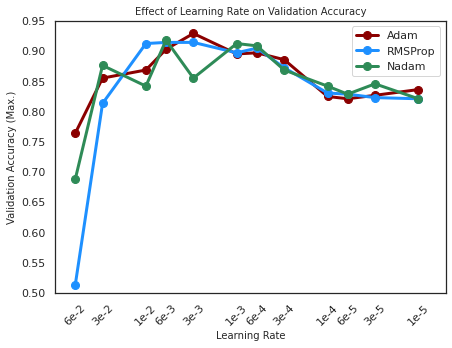

In [ ]:
results = json.load(open(folder_path+'Results/'+'learning_rate.json'))

adam_acc,rmsprop_acc,nadam_acc = validacc_list(results)

lr_range = [6e-2,3e-2,1e-2,6e-3,3e-3,1e-3,
            6e-4,3e-4,1e-4,6e-5,3e-5,1e-5]

xlim = [0.1,5e-6]
ylim = [0.50,0.95]
learning_rate_plot(lr_range,adam_acc,rmsprop_acc,nadam_acc,
                x_label = 'Learning Rate',
                title = 'Effect of Learning Rate on Validation Accuracy',
                x_lim = xlim,y_lim= ylim)

## Error Analysis (Quantative)

In [ ]:
models = ['keras_lstm_att','vgg16','resnet_lstm_att']
model_names = ['Best Textual Model','Best Visual Model','Proposed Model']
class_names = ['ND','DI','DN','Fires','Flood','HD']
def models_confusion_matrix(saved_model,model_name):

  if saved_model == 'keras_lstm_att':
    model = create_lstm_attention_model()
    model.load_weights(folder_path+'Models/'+f"{saved_model}.h5")
    y_pred = np.argmax(model.predict(test_pad_sequences), axis=-1)

  elif saved_model == 'vgg16':
    model = load_model(folder_path+'Models/'+f"{saved_model}.h5")
    y_pred = np.argmax(model.predict(test_image), axis=-1)

  else:
    model = create_lstm_attention_resnet_model ()
    model.load_weights(folder_path+'Models/'+f"{saved_model}.h5")
    y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)


  y_true = test_data['enc_label']
  con_mat(y_true,y_pred,class_names,model_name)

In [ ]:
print (color.BOLD+f"======= Confusion Matrix of best Models  =============\n"+color.END)
for i,model in enumerate(models):
    models_confusion_matrix(model,model_names[i])

In [ ]:
result = pd.read_excel(folder_path+'results.xlsx')

In [ ]:
print_metrices(result['Actual'],result['Proposed Model'])

In [ ]:
result['Best Textual Model'] = result['Best Textual Model'].replace({'ND':0,'DI':1,'DN':2,
                                                       'Fires':3,'Flood':4,'HD':5 })
result['Best Visual Model'] = result['Best Visual Model'].replace({'ND':0,'DI':1,'DN':2,
                                                       'Fires':3,'Flood':4,'HD':5 })
result['Proposed Model'] = result['Proposed Model'].replace({'ND':0,'DI':1,'DN':2,
                                                       'Fires':3,'Flood':4,'HD':5 })
result['Actual'] = result['Actual'].replace({'ND':0,'DI':1,'DN':2,
                                                       'Fires':3,'Flood':4,'HD':5 })
result


In [ ]:
class_names = ['ND','DI','DN','Fires','Flood','HD']

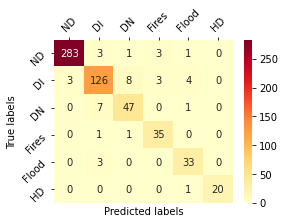

In [ ]:
class_names = ['ND','DI','DN','Fires','Flood','HD']
con_mat(result['Actual'],result['Proposed Model'],class_names,'visual')

## Classification Report Heatmap

In [ ]:
clf_report = classification_report(result['Actual'],
                                   result['Best Textual Model'],
                                   output_dict=True)

clf_report.pop("accuracy")


clf_report['DI (144)'] = clf_report.pop('DI')
clf_report['DN (55)'] = clf_report.pop('DN')
clf_report['Fires (37)'] = clf_report.pop('Fires')
clf_report['Flood (36)'] = clf_report.pop('Flood')
clf_report['HD (21)'] = clf_report.pop('HD')
clf_report['ND (291)'] = clf_report.pop('ND')


clf_report['M. avg'] = clf_report.pop('macro avg')
clf_report['W. avg'] = clf_report.pop('weighted avg')

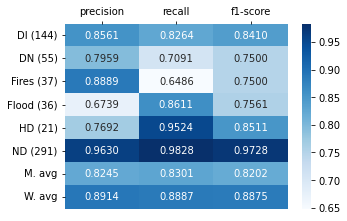

In [ ]:
# .iloc[:-1, :] to exclude support
plt.figure(figsize=(5,3.4))
sns.color_palette()
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, fmt='.4f',cmap = 'Blues',annot=True)
ax.xaxis.set_ticks_position('top')
plt.savefig(folder_path+'cr-textual-2.png',dpi = 500,bbox_inches ='tight')

##Misclassification Rate

In [ ]:
data_matrix = pd.DataFrame({'ND':[12.71,1.72,2.74],
                            'DI':[23,17.36,12.5],
                            'DN':[32.72,29,14.54],
                            'Fires':[10.8,35,5.4],
                            'Flood':[25,13,8.33],
                            'HD':[33,5.0,5.0],
                            'Models':['Best Visual', 'Best Textual','Proposed Multimodal']})
data_matrix

,ND,DI,DN,Fires,Flood,HD,Models
0,12.71,23.00,32.72,10.8,25.00,33.0,Best Visual
1,1.72,17.36,29.00,35.0,13.00,5.0,Best Textual
2,2.74,12.50,14.54,5.4,8.33,5.0,Proposed Multimodal


In [ ]:
df = pd.melt(data_matrix, id_vars='Models', var_name="Category", value_name="Values")
print(df)

                 Models Category  Values
0           Best Visual       ND   12.71
1          Best Textual       ND    1.72
2   Proposed Multimodal       ND    2.74
3           Best Visual       DI   23.00
4          Best Textual       DI   17.36
5   Proposed Multimodal       DI   12.50
6           Best Visual       DN   32.72
7          Best Textual       DN   29.00
8   Proposed Multimodal       DN   14.54
9           Best Visual    Fires   10.80
10         Best Textual    Fires   35.00
11  Proposed Multimodal    Fires    5.40
12          Best Visual    Flood   25.00
13         Best Textual    Flood   13.00
14  Proposed Multimodal    Flood    8.33
15          Best Visual       HD   33.00
16         Best Textual       HD    5.00
17  Proposed Multimodal       HD    5.00


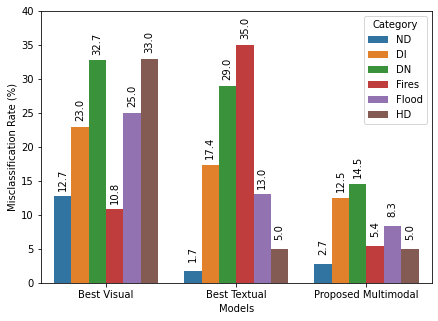

In [ ]:
model_names = ['Best Visual', 'Best Textual','Proposed Multimodal']
plt.figure(figsize=(7, 5))
#ax = plt.subplot()c

splot = sns.barplot(data=df,x='Models', y='Values' ,hue='Category')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 17),
                   textcoords = 'offset points',
                   rotation= 90)

plt.xlabel('Models')
plt.ylabel('Misclassification Rate (%)')
#plt.title('Classwise Misclassification Rate')
plt.ylim([0,40])
plt.xticks([0,1,2],model_names ,rotation = '0')
plt.savefig(folder_path+'ms-rate.png',dpi = 500,bbox_inches ='tight')

##Error Analysis (Qualitative)

In [ ]:
models = ['keras_lstm_att.h5','vgg16.h5','resnet_lstm_att.h5']
model_names = ['Best Textual Model','Best Visual Model','Proposed Model']
class_names = ['ND','DI','DN','Fires','Flood','HD']

  # Define a result table as a DataFrame
result_table = pd.DataFrame({'tweet':test_data['tweet'],'image':test_data['image']})

for i,mn in enumerate(models):

  if mn == 'keras_lstm_att.h5':
    model = create_lstm_attention_model()
    model.load_weights(folder_path+'Models/'+mn)
    y_pred = np.argmax(model.predict(test_pad_sequences), axis=-1)

  elif mn == 'vgg16.h5':
    model = load_model(folder_path+'Models/'+mn)
    y_pred = np.argmax(model.predict(test_image), axis=-1)

  else:
    model = create_lstm_attention_resnet_model ()
    model.load_weights(folder_path+'Models/'+mn)
    y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

  new_pred = y_pred.astype('uint8')

  result_table[model_names[i]] = new_pred
    # Set name of the classifiers as index labels
#result_table.set_index('classifiers', inplace=True)

94773248/94765736 [==============================] - 2s 0us/step


Index(['tweet', 'image', 'Best Textual Model', 'Best Visual Model',
       'Proposed Model', 'Actual'],
      dtype='object')

In [ ]:
## Image Display Function
def display_image(image_name):
  from matplotlib import image as im
  data = im.imread(dataset_path+f'{image_name}')
  plt.figure()
  plt.axis('off')

  plt.imshow(data)
  plt.savefig(folder_path+'Results/'+f'{image_name}.png',bbox_inches ='tight')
  #


In [ ]:
labels = ['ND','DI','DN','Fires','Flood','HD']

def actual_label(row):
    return labels[row]

result_table['Best Textual Model']= result_table['Best Textual Model'].apply(actual_label)
result_table['Best Visual Model']= result_table['Best Visual Model'].apply(actual_label)
result_table['Proposed Model']= result_table['Proposed Model'].apply(actual_label)
result_table['Actual'] = test_data['enc_label'].apply(actual_label)

In [ ]:
result_table[['Best Textual Model', 'Best Visual Model',
       'Proposed Model', 'Actual']].to_excel(folder_path+'results.xlsx',index = False)

Textual Model ===> Flood 
 Visual Model ===> ND 
 Proposed Model ===> DI 
 Actual Label ===> DI 
 Tweet ===> #hurricane #sandy #hurricanesandy #sandydamage #nyc #nj #crane 

Image === >

Textual Model ===> Flood 
 Visual Model ===> DI 
 Proposed Model ===> DN 
 Actual Label ===> DN 
 Tweet ===> Harmful Effects of Landslides | Download PDF and find out more only at ➡➡➡➡ https://www.studytoday.net/effects-landslides/
#landslide#naturaldisaster#earthquake#tsunami#flood#nature#destroy#environment#disaster#tornadoes#huricane#volcaniceruption#draught#cyclone#hailstrom#blizzard#landslide#flooding#stroms#stromchasing#lightning#lightningstrike#thunderstrom#read#learn#write#essay#essayist#essaytime#children#students 

Image === >



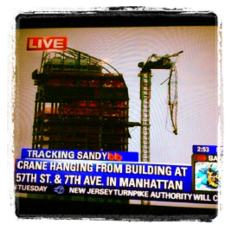

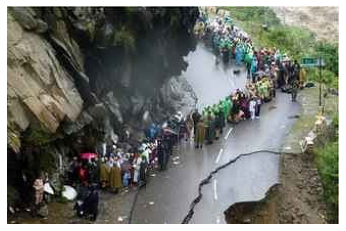

In [ ]:
for i in range(len(result_table)):
    if result_table['Best Textual Model'][i] != result_table['Best Visual Model'][i] and result_table['Proposed Model'][i] !=result_table['Best Textual Model'][i] and result_table['Proposed Model'][i] !=result_table['Best Visual Model'][i] and result_table['Proposed Model'][i] ==result_table['Actual'][i]:
        print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
            'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
            'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
            'Actual Label ===>',result_table['Actual'][i],'\n',
            'Tweet ===>',result_table['tweet'][i],'\n'
            )
        print('Image === >\n')
        display_image(result_table['image'][i])



Textual Model ===> DN 
 Visual Model ===> DN 
 Proposed Model ===> ND 
 Actual Label ===> ND 
 Tweet ===> #MooseMonday with my favorites! A couple #bullmoose from the weekend! 💜🦌🖤
•
•
•
#moose #wildlife #wildlifephotography #mammal #wilderness #wildernessculture #wild #wildvisuals #mountainlife #thegreatoutdoors #nature #naturegirl #naturelovers #viewsfromcolorado #coloradowild #coloradolive #coloradotography #coloradocreative #coloradocameraclub #colorado_photographers #coloradolife © Laura Sheets 

Image === >

Textual Model ===> DN 
 Visual Model ===> DN 
 Proposed Model ===> DI 
 Actual Label ===> DI 
 Tweet ===> #sandy #youwhore massive #treebranch fell and took out two 8 foot sections of the fence in the pic.(only the other side of their yard) #fallentree #30ftdrop #sandydamage 

Image === >

Textual Model ===> DI 
 Visual Model ===> DI 
 Proposed Model ===> DN 
 Actual Label ===> DN 
 Tweet ===> @ucirvine @ocparks @irvinepolice  #etal ,

Please curtail this hazardous 20+ year pr

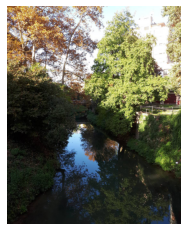

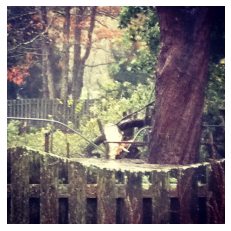

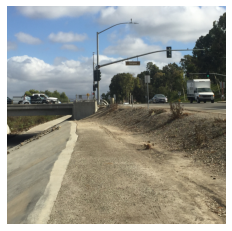

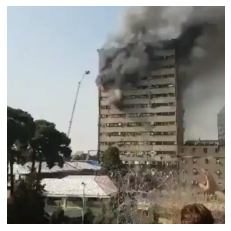

In [ ]:
for i in range(len(result_table)):
    if result_table['Best Textual Model'][i] == result_table['Best Visual Model'][i] != result_table['Proposed Model'][i]== result_table["Actual"][i]:
        print('Textual Model ===>',result_table['Best Textual Model'][i],'\n',
            'Visual Model ===>',result_table['Best Visual Model'][i],'\n',
            'Proposed Model ===>',result_table['Proposed Model'][i],'\n',
            'Actual Label ===>',result_table['Actual'][i],'\n',
            'Tweet ===>',result_table['tweet'][i],'\n'
            )
        print('Image === >\n')
        display_image(result_table['image'][i])


In [ ]:
result_table['Actual'].value_counts()

non_damage                291
damaged_infrastructure    144
damaged_nature             55
fires                      37
flood                      36
human_damage               21
Name: Actual, dtype: int64

## Feature Visualization

In [ ]:
from keras.utils import to_categorical
y_train=to_categorical(train_data['enc_label'])
y_test=to_categorical(test_data['enc_label'])

In [ ]:
model = create_lstm_attention_model()
# Load the saved model
model.load_weights(folder_path+'Models/'+ 'keras_lstm_att.h5')
y_pred = np.argmax(model.predict(test_pad_sequences), axis=-1)

In [ ]:
model = load_model(folder_path+'Models/'+'vgg16.h5')
y_pred = np.argmax(model.predict(test_image), axis=-1)

In [ ]:
model = create_lstm_attention_resnet_model()
# Load the saved model
model.load_weights(folder_path+'Models/'+'resnet_lstm_att.h5')
y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
model = create_lstm_attention_model()
for layer in model.layers:
    print(layer.name, layer.trainable)
    print('Layer Configuration:')
    print(layer.get_config(), end='\n{}\n'.format('----'*10))

In [ ]:
def create_truncated_model(trained_model):

    #model = load_model(folder_path+'Models/'+'vgg16.h5')
    #
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

# model = create_lstm_attention_resnet_model()
# model.load_weights(folder_path+'Models/'+ 'resnet_lstm_att.h5')

model = load_model(folder_path+'Models/'+'resnetLSTM.h5')

truncated_model = create_truncated_model(model)
hidden_features = truncated_model.predict([test_image,test_pad_sequences])

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=5)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 0.993621154832802

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, perplexity=20, verbose = 1)
tsne_results = tsne.fit_transform(pca_result)

Variance PCA: 1.0
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 584 samples in 0.000s...
[t-SNE] Computed neighbors for 584 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 584 / 584
[t-SNE] Mean sigma: 0.000001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.049843
[t-SNE] KL divergence after 1000 iterations: 0.152741


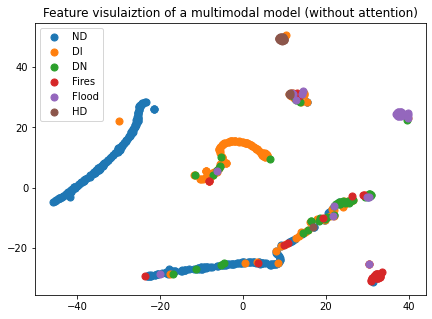

In [ ]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_cat = np_utils.to_categorical(test_data['enc_label'], num_classes = 6)
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(7,5))
class_labels = ['ND','DI','DN','Fires','Flood','HD']
for i,cl in enumerate(range(6)):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=class_labels[i],marker='o',s=50)
plt.title('Feature visulaiztion of a multimodal model (without attention)')
plt.legend()
plt.savefig(folder_path+'fv.png',dpi = 700,bbox_inches ='tight')
plt.show()



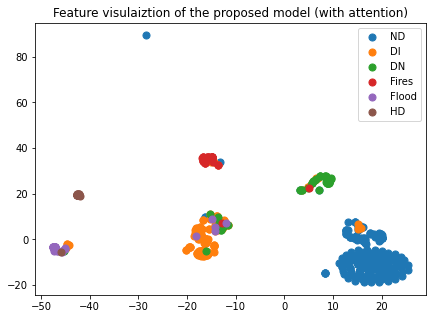

In [ ]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_cat = np_utils.to_categorical(test_data['enc_label'], num_classes = 6)
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(7,5))
class_labels = ['ND','DI','DN','Fires','Flood','HD']
for i,cl in enumerate(range(6)):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=class_labels[i],marker='o',s=50)
plt.title('Feature visulaiztion of the proposed model (with attention)')
plt.legend()
plt.savefig(folder_path+'fv-a.png',dpi = 700,bbox_inches ='tight')
plt.show()



## Comparison

In [ ]:
#     ********************************** Ferda, Firoj et. al ***************

# VGG16 + CNN with GloVe

def create_glove_embeddings():
# load the whole embedding into memory
  embeddings_index = dict()
  f = open(pretrained_path+'glove.840B.300d.sst.txt')
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()
  print('Loaded %s word vectors.' % len(embeddings_index))

  # create a weight matrix for words in training docs
  embedding_matrix = np.zeros((vocab_size, 300))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

  return embedding_matrix

# Call the function
embedding_matrix = create_glove_embeddings()
keras.backend.clear_session()

def create_ferda_model ():
  # create the base pre-trained model
  vgg = VGG16(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  x = vgg.output
  # let's add a fully-connected layer
  flat = Flatten()(x)
  hidden1 = Dense(1000, activation='relu')(flat)
  # this is the model we will train
  vgg_img_model = Model(inputs=vgg.input, outputs=hidden1)


  # Text Model
  cnn_text_inputs = Input(shape=(max_len,))
  cnn_embedding_layer = Embedding(vocab_size,300, weights=[embedding_matrix], trainable=False)(cnn_text_inputs)
  cnn_conv1 = Conv1D(100,2,activation='relu')(cnn_embedding_layer)
  cnn_pool1 = MaxPooling1D(2)(cnn_conv1)
  cnn_conv2 = Conv1D(150,3,activation='relu')(cnn_pool1)
  cnn_pool2 = MaxPooling1D(3)(cnn_conv2)
  cnn_conv3 = Conv1D(200,4,activation='relu')(cnn_pool2)
  cnn_pool3 = MaxPooling1D(4)(cnn_conv3)
  cnn_flat = Flatten()(cnn_pool3)
  cnn_dense_layer_1 = Dense(1000, activation='relu')(cnn_flat)
  cnn_model = Model(inputs=cnn_text_inputs, outputs=cnn_dense_layer_1)

  # Concatenating the output of 2 classifiers
  con_layer = keras.layers.concatenate([vgg_img_model.output, cnn_model.output])
  dropout = Dropout(0.2)(con_layer)
  out = Dense(6,activation='softmax')(dropout)

  #Defining model input and output
  com_model = Model(inputs = [vgg_img_model.input, cnn_model.input], outputs=out)

  return com_model


Loaded 20725 word vectors.


In [ ]:
model = create_ferda_model ()
model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=Adam(learning_rate=1e-6),
                      metrics = ["accuracy"])


In [ ]:
model.fit([train_image,train_pad_sequences],
          train_data['enc_label'],
          batch_size=32,
          epochs=50,
          validation_split=0.10,
          verbose =1,
          callbacks = callbacks_check('ferda_model') )

In [ ]:
model = load_model(folder_path+'Models/'+"ferda_model.h5")
y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[262  11   7   7   2   2]
 [ 25 100  12   2   4   1]
 [  7  17  23   1   6   1]
 [  6   2   1  27   1   0]
 [  5   2   2   2  25   0]
 [ 12   3   0   0   0   6]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       291
           1       0.74      0.69      0.72       144
           2       0.51      0.42      0.46        55
           3       0.69      0.73      0.71        37
           4       0.66      0.69      0.68        36
           5       0.60      0.29      0.39        21

    accuracy                           0.76       584
   macro avg       0.67      0.62      0.64       584
weighted avg       0.75      0.76      0.75       584

Accuracy :  0.7585616438356164
Precison :  0.7486102978235306
Recall :  0.7585616438356164
F1 :  0.7501107694345739


In [ ]:
#     ********************************** Abhinav et. al ***************

# VGG16 + LSTM with GloVe

def create_glove_embeddings():
# load the whole embedding into memory
  embeddings_index = dict()
  f = open(pretrained_path+'glove.840B.300d.sst.txt')
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()
  print('Loaded %s word vectors.' % len(embeddings_index))

  # create a weight matrix for words in training docs
  embedding_matrix = np.zeros((vocab_size, 300))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

  return embedding_matrix

# Call the function
embedding_matrix = create_glove_embeddings()
keras.backend.clear_session()

def create_abhinav_model ():
  # create the base pre-trained model
  vgg = VGG16(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  x = vgg.output
  # let's add a fully-connected layer
  flat = Flatten()(x)
  hidden1 = Dense(512, activation='relu')(flat)
  # this is the model we will train
  vgg_img_model = Model(inputs=vgg.input, outputs=hidden1)


  # Text Model
  ###### BiLSTM Model #######
  bi_text_inputs = Input(shape=(max_len,))
  bi_embedding_layer = Embedding(vocab_size,300, weights=[embedding_matrix], trainable=False)(bi_text_inputs)
  LSTM_Layer_1 = Bidirectional(LSTM(30,return_sequences=True))(bi_embedding_layer)
  LSTM_Layer_2 = Bidirectional(LSTM(30))(LSTM_Layer_1)

  bi_dense_layer_1 = Dense(512, activation='relu')(LSTM_Layer_2)
  bilstm_model = Model(inputs=bi_text_inputs, outputs=bi_dense_layer_1)

  # Concatenating the output of 2 classifiers
  con_layer = keras.layers.concatenate([vgg_img_model.output, bilstm_model.output])
  dropout = Dropout(0.2)(con_layer)
  out = Dense(6,activation='softmax')(dropout)

  #Defining model input and output
  com_model = Model(inputs = [vgg_img_model.input, bilstm_model.input], outputs=out)

  return com_model


Loaded 20725 word vectors.


In [ ]:
model = create_abhinav_model ()
model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=Adam(learning_rate=0.001,),
                      metrics = ["accuracy"])


In [ ]:
model.fit([train_image,train_pad_sequences],
          train_data['enc_label'],
          batch_size=32,
          epochs=50,
          validation_split=0.10,
          verbose =1,
          callbacks = callbacks_check('abhinav_model') )

In [ ]:
model = load_model(folder_path+'Models/'+"abhinav_model.h5")
y_pred = np.argmax(model.predict([test_image,test_pad_sequences]), axis=-1)

y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[265  20   4   1   1   0]
 [  6 117   7   3   8   3]
 [  1  22  20   1  11   0]
 [  0  12   2  19   2   2]
 [  1  13   0   2  20   0]
 [  0   3   0   2   2  14]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       291
           1       0.63      0.81      0.71       144
           2       0.61      0.36      0.45        55
           3       0.68      0.51      0.58        37
           4       0.45      0.56      0.50        36
           5       0.74      0.67      0.70        21

    accuracy                           0.78       584
   macro avg       0.68      0.64      0.65       584
weighted avg       0.79      0.78      0.78       584

Accuracy :  0.7791095890410958
Precison :  0.792545515276812
Recall :  0.7791095890410958
F1 :  0.7784055141590532


In [ ]:
#  ********************************** Nguyen et. al (Image) ***************
keras.backend.clear_session()
# create the base pre-trained model
vgg = VGG16(weights='imagenet', include_top=False,input_shape=(150, 150, 3))

x = vgg.output
flat = Flatten()(x)
output = Dense(6, activation='softmax')(flat)
  # this is the model we will train
Ng_img_model = Model(inputs=vgg.input, outputs=output)

In [ ]:
Ng_img_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=Adam(learning_rate=2e-4,),
                      metrics = ["accuracy"])


In [ ]:
Ng_img_model.fit(train_image,
          train_data['enc_label'],
          batch_size=32,
          epochs=50,
          validation_split=0.10,
          verbose =1,
          callbacks = callbacks_check('Ng_model') )

In [ ]:
model = load_model(folder_path+'Models/'+"Ng_model.h5")
y_pred = np.argmax(model.predict(test_image,), axis=-1)

y_true = test_data['enc_label']
print_metrices(y_true,y_pred)

[[246  17  14   6   5   3]
 [ 16  92  24   2   6   4]
 [  2  10  35   1   5   2]
 [  5   1   2  29   0   0]
 [  4   9   4   1  18   0]
 [  3   1   0   0   1  16]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       291
           1       0.71      0.64      0.67       144
           2       0.44      0.64      0.52        55
           3       0.74      0.78      0.76        37
           4       0.51      0.50      0.51        36
           5       0.64      0.76      0.70        21

    accuracy                           0.75       584
   macro avg       0.66      0.69      0.67       584
weighted avg       0.76      0.75      0.75       584

Accuracy :  0.7465753424657534
Precison :  0.7621771444516864
Recall :  0.7465753424657534
F1 :  0.7517792270594581


In [ ]:
###    ****Caragea et al.

# ##### CNN Model  #######
# cnn_text_inputs = Input(shape=(max_len,))
# cnn_embedding_layer = Embedding(vocab_size, 100)(cnn_text_inputs)
# cnn_conv1 = Conv1D(128,2,activation='relu')(cnn_embedding_layer)
# cnn_conv2 = Conv1D(64,2,activation='relu')(cnn_conv1)
# cnn_pool1 = MaxPooling1D(2)(cnn_conv1)
# cnn_flat = Flatten()(cnn_pool1)
# cnn_dense_layer_1 = Dense(6, activation='softmax')(cnn_flat)
# cr_model = Model(inputs=cnn_text_inputs, outputs=cnn_dense_layer_1)

###    ****Aipe et al.
##### CNN Model  #######
# cnn_text_inputs = Input(shape=(max_len,))
# cnn_embedding_layer = Embedding(vocab_size, 100)(cnn_text_inputs)
# cnn_conv1 = Conv1D(128,4,activation='relu')(cnn_embedding_layer)
# cnn_conv2 = Conv1D(64,2,activation='relu')(cnn_conv1)
# cnn_conv3 = Conv1D(32,4,activation='relu')(cnn_conv2)
# cnn_conv4 = Conv1D(14,2,activation='relu')(cnn_conv3)
# cnn_pool1 = MaxPooling1D(2)(cnn_conv4)
# cnn_flat = Flatten()(cnn_pool1)
# cnn_dense_layer_1 = Dense(6, activation='softmax')(cnn_flat)
# aipe_model = Model(inputs=cnn_text_inputs, outputs=cnn_dense_layer_1)

###    ****Yu et al.

# Text Model
cnn_text_inputs = Input(shape=(max_len,))
cnn_embedding_layer = Embedding(vocab_size,300, weights=[embedding_matrix], trainable=False)(cnn_text_inputs)
cnn_conv1 = Conv1D(100,2,activation='relu')(cnn_embedding_layer)
cnn_pool1 = MaxPooling1D(2)(cnn_conv1)
cnn_conv2 = Conv1D(150,3,activation='relu')(cnn_pool1)
cnn_pool2 = MaxPooling1D(3)(cnn_conv2)
cnn_conv3 = Conv1D(200,4,activation='relu')(cnn_pool2)
cnn_pool3 = MaxPooling1D(4)(cnn_conv3)
cnn_flat = Flatten()(cnn_pool3)
cnn_dense_layer_1 = Dense(6, activation='softmax')(cnn_flat)
yu_model = Model(inputs=cnn_text_inputs, outputs=cnn_dense_layer_1)

In [ ]:
yu_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=Adam(learning_rate=1e-3,),
                      metrics = ["accuracy"])


yu_model.fit(train_pad_sequences,
          train_data['enc_label'],
          batch_size=32,
          epochs=50,
          validation_split=0.10,
          verbose =1,
          callbacks = callbacks_check('yu_model') )

Epoch 1/50
148/148 [==============================] - 1s 6ms/step - loss: 0.6962 - accuracy: 0.7416 - val_loss: 0.6917 - val_accuracy: 0.7467

Epoch 00001: val_accuracy improved from -inf to 0.74667, saving model to /content/drive/MyDrive/Colab Notebooks/MSC Presentation Tasks/Disaster Response/Models/yu_model.h5
Epoch 2/50
148/148 [==============================] - 1s 4ms/step - loss: 0.5296 - accuracy: 0.8041 - val_loss: 0.6348 - val_accuracy: 0.7695

Epoch 00002: val_accuracy improved from 0.74667 to 0.76952, saving model to /content/drive/MyDrive/Colab Notebooks/MSC Presentation Tasks/Disaster Response/Models/yu_model.h5
Epoch 3/50
148/148 [==============================] - 1s 4ms/step - loss: 0.4359 - accuracy: 0.8439 - val_loss: 0.6485 - val_accuracy: 0.7829

Epoch 00003: val_accuracy improved from 0.76952 to 0.78286, saving model to /content/drive/MyDrive/Colab Notebooks/MSC Presentation Tasks/Disaster Response/Models/yu_model.h5
Epoch 4/50
148/148 [=============================

In [ ]:
## **** Huang et. al

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

## TF-IDF

vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split())
vectorised_posts = vectorizer.fit_transform(train_data['cleaned'])
vectorized_train_posts = vectorizer.transform(train_data['cleaned'])
vectorized_test_posts = vectorizer.transform(test_data['cleaned'])

print("Feature Size: ", vectorized_train_posts.shape[1])
#vectorizer.vocabulary_

Feature Size:  40197


In [ ]:
# After Tunning
# Optimum C = 100
lr = LogisticRegression()
lr.fit(vectorized_train_posts,train_data['enc_label'])
y_pred = lr.predict(vectorized_test_posts)
print_metrices(test_data['enc_label'],y_pred)

[[290   1   0   0   0   0]
 [ 13 123   3   1   4   0]
 [  8  11  34   1   1   0]
 [ 13   4   0  19   0   1]
 [  3   5   1   0  27   0]
 [  1   5   0   0   1  14]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       291
           1       0.83      0.85      0.84       144
           2       0.89      0.62      0.73        55
           3       0.90      0.51      0.66        37
           4       0.82      0.75      0.78        36
           5       0.93      0.67      0.78        21

    accuracy                           0.87       584
   macro avg       0.88      0.73      0.79       584
weighted avg       0.87      0.87      0.86       584

Accuracy :  0.8681506849315068
Precison :  0.8696923473182459
Recall :  0.8681506849315068
F1 :  0.8604970770584339


#5 Fold Cross Validation

## LSTM + Attention (KE)

In [ ]:
from sklearn.model_selection import StratifiedKFold
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# split into input (X) and output (Y) variables
X = train_pad_sequences
Y = train_data['enc_label']
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
  # create model
	model = create_lstm_attention_model ()
	# Compile model
	model.compile(loss='sparse_categorical_crossentropy',
              optimizer= keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])
	# Fit the model
	model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
  model.fit(X[train], Y[train],
                    batch_size=32,
                    epochs=50,
                    verbose = 0 )
	# evaluate the model
  y_pred = np.argmax(model.predict(X[test], Y[test]))
  scores= f1_score(Y[test], y_pred,average = 'weighted')*100
	cvscores.append(scores)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

##ResNet50

In [ ]:
#### Resnet
resnet = ResNet50(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
#resnet.trainable = False
for layer in resnet.layers[0:-10]:
    layer.trainable = False
# add a global spatial average pooling layer
y = resnet.output
pool1 = GlobalAveragePooling2D()(y)
# let's add a fully-connected layer
#flat1 = Flatten()(pool1)
# and a logistic layer -- let's say we have 200 classes
#hidden = Dense(512, activation='relu')(flat1)
#dropout1 = Dropout(0.1)(hidden)
output1 = Dense(6, activation='softmax')(pool1)
# this is the model we will train
resnet_img_model = Model(inputs=resnet.input, outputs=output1)

In [ ]:
from sklearn.model_selection import StratifiedKFold
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# split into input (X) and output (Y) variables
X = train_image
Y = train_data['enc_label']
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
  # create model
	model = resnet_img_model
	# Compile model
	model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
                      metrics = ["accuracy"])
	# Fit the model
	model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
  model.fit(X[train], Y[train],
                    batch_size=32,
                    epochs=50,
                    verbose = 0 )
	# evaluate the model
  y_pred = np.argmax(model.predict(X[test], Y[test]))
  scores= f1_score(Y[test], y_pred,average = 'weighted')*100
	cvscores.append(scores)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

##LSTM+ATT+VGG16

In [ ]:
from sklearn.model_selection import StratifiedKFold
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# split into input (X) and output (Y) variables
X = [train_image,train_pad_sequences]
Y = train_data['enc_label']
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
  # create model
	model = create_lstm_attention_vgg16_model()
	# Compile model
	model.compile(loss='categorical_crossentropy',
                      optimizer=RMSprop(),
                      metrics = ["accuracy"])
	# Fit the model
	model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
  model.fit(X[train], Y[train],
                    batch_size=32,
                    epochs=50,
                    verbose = 0 )
	# evaluate the model
  y_pred = np.argmax(model.predict(X[test], Y[test]))
  scores= f1_score(Y[test], y_pred,average = 'weighted')*100
	cvscores.append(scores)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

##Proposed Method

In [ ]:
from sklearn.model_selection import StratifiedKFold
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# split into input (X) and output (Y) variables
X = [train_image,train_pad_sequences]
Y = train_data['enc_label']
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
  # create model
	model = create_lstm_attention_resnet_model()
	# Compile model
  model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics = ["accuracy"])
	# Fit the model
	model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
  model.fit(X[train], Y[train],
                    batch_size=32,
                    epochs=50,
                    verbose = 0 )
	# evaluate the model
  y_pred = np.argmax(model.predict(X[test], Y[test]))
  scores= f1_score(Y[test], y_pred,average = 'weighted')*100
	cvscores.append(scores)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))